In [1]:
import torch
import torch.nn as nn
import torch_geometric
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
import json
import os
from datasets import load_dataset

c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\Carlos\anaconda3\envs\pytorch\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


 Similarity metrics

In [2]:
def polynomial_kernel(X, Y, degree=2, gamma=1.0, coef0=1.0):
    """
    Polynomial kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param degree: int, default=2
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = (gamma * torch.mm(X, Y.t()) + coef0) ** degree
    return K

def rbf_kernel(X, Y, gamma=None):

    """
    Rbf kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||^2)
    d_XY = torch.cdist(X, Y, p=2) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY ** 2)

    return K

def laplacian_kernel(X, Y, gamma=None):
    """
    Laplacian kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||)
    d_XY = torch.cdist(X, Y, p=1) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY)

    return K

def sigmoid_kernel(X, Y, gamma=1.0, coef0=1.0):
    """
    Sigmoid kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = torch.tanh(gamma * torch.mm(X, Y.t()) + coef0)
    return K

In [3]:
def binary_distance(X, Y):
    """Compute distance matrix between  rows of X, Y.

    d(x_i, y_j) = 1 if x_i == y_j, 0 in other case.

    for all rows x_i in X, y_j in Y

    """
    return (X.unsqueeze(1) == Y.unsqueeze(0)).all(-1).float()


def kernel(X, *args, **kwargs):
    """
    Compute similarity matrix of an array X using a variety of kernels
    Parameters:
        X = input data (torch.Tensor or numpy array)
    """
    # kernel parameters

    degree = kwargs.get("degree", None)
    gamma = kwargs.get("gamma", None)
    coef = kwargs.get("coef", None)
    kernel_type = kwargs.get("kernel_type", None)

    if kernel_type == "polynomial":


        # K(x,y) = (gamma * <x,y> + coef)^degree, for vectors x,y

        if (gamma != None) & (coef != None) & (degree != None):
            return polynomial_kernel(X = X, Y = X, degree = degree, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "sigmoid":
 
        # K(x,y) = tanh(gamma * <x,y> + coef), for vectors x,y

        if (gamma != None) & (coef != None):
            return sigmoid_kernel(X = X, Y = X, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "rbf":

        # K(x, y) = exp(-gamma ||x-y||^2)

        if (gamma != None):
            return rbf_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    elif kernel_type == "laplacian":

        # K(x, y) = exp(-gamma ||x-y||_1)

        if (gamma != None):
            return laplacian_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    else:
        return None


Model definition

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, latent_size)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        return x

class GCNDecoder(nn.Module):

    def __init__(self, latent_size, output_size):
        super().__init__()
        self.conv1 = GCNConv(latent_size, output_size)

    def forward(self, z, edge_index, edge_weight=None):
        z = F.relu(self.conv1(x = z, edge_index = edge_index, edge_weight = edge_weight))
        return z

class GAE(nn.Module):

    def __init__(self, encoder, decoder, kernel_parameters_X, optimizer, criterion, label_indep = False, kernel_parameters_Y = None, lam=0.3):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.kernel_parameters_X = kernel_parameters_X
        self.kernel_parameters_Y = kernel_parameters_Y
        self.label_indep = label_indep
        self.optimizer = optimizer
        self.criterion = criterion
        self.lam = lam

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z, edge_index, edge_weight=None):
        return self.decoder(z, edge_index, edge_weight)

    # def forward(self, x, edge_index, edge_weight=None):
    #     z = self.encode(x, edge_index, edge_weight)
    #     return self.decode(z, edge_index, edge_weight)

    def train_model(self, data_loader):
        self.train()

        epoch_losses = [] # log of each minibatch loss
        sup_losses = []
        recon_losses = []

        for X, y in tqdm(data_loader):
            self.optimizer.zero_grad()

            # graph construction
            K_X = kernel(X, **self.kernel_parameters_X)

            if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

            else:
                if self.kernel_parameters_Y == None:
                    self.kernel_parameters_Y = self.kernel_parameters_X

                K_Y = kernel(y, **self.kernel_parameters_Y)

            K_XY = K_X * K_Y # joint similarity matrix

            edge_index, edge_weight = dense_to_sparse(K_XY)
            Z = self.encode(X)
            distance_matrix = torch.cdist(Z, Z, p=2)
            out = self.decode(Z, edge_index, edge_weight) 
            sup_loss = torch.sum(K_XY * distance_matrix)
            recon_loss = self.criterion(out, X)
            loss = self.lam * sup_loss + (1-self.lam) * recon_loss

            epoch_losses.append(loss)
            sup_losses.append(sup_loss)
            recon_losses.append(recon_loss)

            loss.backward()
            self.optimizer.step()

        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        avg_sup_loss = torch.mean(torch.Tensor(sup_losses))
        avg_recon_loss = torch.mean(torch.Tensor(recon_losses))

        return avg_loss.item(), avg_sup_loss.item(), avg_recon_loss.item()

    def test_model(self, data_loader):
        self.eval()
        epoch_losses = []
        sup_losses = []
        recon_losses = []

        with torch.no_grad():
            for X, y in data_loader:
                # graph construction
                K_X = kernel(X, **self.kernel_parameters_X)

                if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                    K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

                else:
                    if self.kernel_parameters_Y == None:
                        self.kernel_parameters_Y = self.kernel_parameters_X

                    K_Y = kernel(y, **self.kernel_parameters_Y)

                K_XY = K_X * K_Y # joint similarity matrix

                edge_index, edge_weight = dense_to_sparse(K_XY)

                Z = self.encode(X)
                distance_matrix = torch.cdist(Z, Z, p=2)
                out = self.decode(Z, edge_index, edge_weight)

                sup_loss = torch.sum(K_XY * distance_matrix)
                recon_loss = self.criterion(out, X)
                loss = self.lam * sup_loss + (1-self.lam) * recon_loss

                epoch_losses.append(loss)
                sup_losses.append(sup_loss)
                recon_losses.append(recon_loss)

        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        avg_sup_loss = torch.mean(torch.Tensor(sup_losses))
        avg_recon_loss = torch.mean(torch.Tensor(recon_losses))

        return avg_loss.item(), avg_sup_loss.item(), avg_recon_loss.item()

Model hyperparameters

In [5]:
lr = 0.0001 # learning rate
batch_size = 256
epochs = 200
latent_size = 64 # latent space dimension

kernel_param_X = {

    "kernel_type": "rbf",
    "degree": 3,
    "gamma": 5,
    "coef": 0

}

# kernel function parameters for Y_train / Y_test. If is equal to None, we use the same parameters.

kernel_param_Y = None

"""
kernel_param_Y = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1.,
    "coef": 1.

}
"""

label_indep = True # True for categoric labels, False for numerical labels

CIFAR10 preprocessing

In [6]:
def create_cifar_10_dataset(dataset):
    df = pd.DataFrame(dataset)
    img_array = np.stack(df["img"].apply(lambda x: np.array(x).flatten()))
    columns = [f"pixel_{i}" for i in range(img_array.shape[1])]
    labels = pd.DataFrame(df["label"], columns = ["label"])
    df = pd.DataFrame(img_array, columns = columns)
    df = pd.concat([df, labels], axis = 1)
    return df

# load CIFAR10 dataset and process it as a dataframe with pixel values and labels

data = load_dataset("cifar10")

train_data = create_cifar_10_dataset(data["train"])
test_data = create_cifar_10_dataset(data["test"])

train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42, shuffle=True, stratify=train_data["label"])

X_train = train_data.drop("label", axis = 1)/255.
y_train = train_data["label"]
X_train = torch.tensor(X_train.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
X_val = val_data.drop("label", axis=1)/255.
X_val = torch.tensor(X_val.values, dtype=torch.float)
y_val = val_data["label"]
y_val = torch.tensor(y_val.values, dtype=torch.float)
X_test = test_data.drop("label", axis=1)/255.
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_test = test_data["label"]
y_test = torch.tensor(y_test.values, dtype=torch.float)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)
input_size = X_train.size(1)

Model creation

In [48]:
model_encoder = Encoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y, lam=0)


Model training

In [49]:
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    avg_loss_train, avg_sup_loss_train, avg_recon_loss_train = model.train_model(train_loader)
    avg_loss_val, avg_sup_loss_val, avg_recon_loss_val = model.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_sup_loss_train: {avg_sup_loss_train:.4f}, avg_recon_loss_train: {avg_recon_loss_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_sup_loss_val: {avg_sup_loss_val:.4f}, avg_recon_loss_val: {avg_recon_loss_val:.4f}")


Epoch: 1/200


100%|██████████| 176/176 [00:10<00:00, 17.40it/s]


avg_loss_train: 0.1532, avg_sup_loss_train: 0.5159, avg_recon_loss_train: 0.1532
avg_loss_val: 0.1348, avg_sup_loss_val: 0.5321, avg_recon_loss_val: 0.1348
Epoch: 2/200


100%|██████████| 176/176 [00:10<00:00, 17.52it/s]


avg_loss_train: 0.1202, avg_sup_loss_train: 0.5892, avg_recon_loss_train: 0.1202
avg_loss_val: 0.1091, avg_sup_loss_val: 0.5925, avg_recon_loss_val: 0.1091
Epoch: 3/200


100%|██████████| 176/176 [00:10<00:00, 17.40it/s]


avg_loss_train: 0.0939, avg_sup_loss_train: 0.6148, avg_recon_loss_train: 0.0939
avg_loss_val: 0.0846, avg_sup_loss_val: 0.6029, avg_recon_loss_val: 0.0846
Epoch: 4/200


100%|██████████| 176/176 [00:10<00:00, 17.37it/s]


avg_loss_train: 0.0750, avg_sup_loss_train: 0.6424, avg_recon_loss_train: 0.0750
avg_loss_val: 0.0679, avg_sup_loss_val: 0.6448, avg_recon_loss_val: 0.0679
Epoch: 5/200


100%|██████████| 176/176 [00:10<00:00, 17.44it/s]


avg_loss_train: 0.0590, avg_sup_loss_train: 0.6364, avg_recon_loss_train: 0.0590
avg_loss_val: 0.0533, avg_sup_loss_val: 0.6574, avg_recon_loss_val: 0.0533
Epoch: 6/200


100%|██████████| 176/176 [00:10<00:00, 17.18it/s]


avg_loss_train: 0.0492, avg_sup_loss_train: 0.6621, avg_recon_loss_train: 0.0492
avg_loss_val: 0.0469, avg_sup_loss_val: 0.6612, avg_recon_loss_val: 0.0469
Epoch: 7/200


100%|██████████| 176/176 [00:10<00:00, 17.24it/s]


avg_loss_train: 0.0445, avg_sup_loss_train: 0.6821, avg_recon_loss_train: 0.0445
avg_loss_val: 0.0434, avg_sup_loss_val: 0.7109, avg_recon_loss_val: 0.0434
Epoch: 8/200


100%|██████████| 176/176 [00:10<00:00, 17.50it/s]


avg_loss_train: 0.0414, avg_sup_loss_train: 0.7031, avg_recon_loss_train: 0.0414
avg_loss_val: 0.0407, avg_sup_loss_val: 0.6971, avg_recon_loss_val: 0.0407
Epoch: 9/200


100%|██████████| 176/176 [00:10<00:00, 17.24it/s]


avg_loss_train: 0.0394, avg_sup_loss_train: 0.7208, avg_recon_loss_train: 0.0394
avg_loss_val: 0.0389, avg_sup_loss_val: 0.7396, avg_recon_loss_val: 0.0389
Epoch: 10/200


100%|██████████| 176/176 [00:10<00:00, 17.04it/s]


avg_loss_train: 0.0374, avg_sup_loss_train: 0.7419, avg_recon_loss_train: 0.0374
avg_loss_val: 0.0364, avg_sup_loss_val: 0.7526, avg_recon_loss_val: 0.0364
Epoch: 11/200


100%|██████████| 176/176 [00:10<00:00, 17.12it/s]


avg_loss_train: 0.0347, avg_sup_loss_train: 0.7701, avg_recon_loss_train: 0.0347
avg_loss_val: 0.0338, avg_sup_loss_val: 0.7507, avg_recon_loss_val: 0.0338
Epoch: 12/200


100%|██████████| 176/176 [00:10<00:00, 17.30it/s]


avg_loss_train: 0.0326, avg_sup_loss_train: 0.7885, avg_recon_loss_train: 0.0326
avg_loss_val: 0.0324, avg_sup_loss_val: 0.7944, avg_recon_loss_val: 0.0324
Epoch: 13/200


100%|██████████| 176/176 [00:10<00:00, 16.88it/s]


avg_loss_train: 0.0313, avg_sup_loss_train: 0.8076, avg_recon_loss_train: 0.0313
avg_loss_val: 0.0314, avg_sup_loss_val: 0.8419, avg_recon_loss_val: 0.0314
Epoch: 14/200


100%|██████████| 176/176 [00:10<00:00, 17.26it/s]


avg_loss_train: 0.0303, avg_sup_loss_train: 0.8251, avg_recon_loss_train: 0.0303
avg_loss_val: 0.0303, avg_sup_loss_val: 0.7976, avg_recon_loss_val: 0.0303
Epoch: 15/200


100%|██████████| 176/176 [00:10<00:00, 17.06it/s]


avg_loss_train: 0.0295, avg_sup_loss_train: 0.8428, avg_recon_loss_train: 0.0295
avg_loss_val: 0.0296, avg_sup_loss_val: 0.8518, avg_recon_loss_val: 0.0296
Epoch: 16/200


100%|██████████| 176/176 [00:10<00:00, 17.03it/s]


avg_loss_train: 0.0290, avg_sup_loss_train: 0.8538, avg_recon_loss_train: 0.0290
avg_loss_val: 0.0290, avg_sup_loss_val: 0.8908, avg_recon_loss_val: 0.0290
Epoch: 17/200


100%|██████████| 176/176 [00:10<00:00, 17.30it/s]


avg_loss_train: 0.0284, avg_sup_loss_train: 0.8703, avg_recon_loss_train: 0.0284
avg_loss_val: 0.0285, avg_sup_loss_val: 0.8465, avg_recon_loss_val: 0.0285
Epoch: 18/200


100%|██████████| 176/176 [00:10<00:00, 17.29it/s]


avg_loss_train: 0.0278, avg_sup_loss_train: 0.8802, avg_recon_loss_train: 0.0278
avg_loss_val: 0.0279, avg_sup_loss_val: 0.8649, avg_recon_loss_val: 0.0279
Epoch: 19/200


100%|██████████| 176/176 [00:10<00:00, 17.38it/s]


avg_loss_train: 0.0273, avg_sup_loss_train: 0.8959, avg_recon_loss_train: 0.0273
avg_loss_val: 0.0273, avg_sup_loss_val: 0.9002, avg_recon_loss_val: 0.0273
Epoch: 20/200


100%|██████████| 176/176 [00:10<00:00, 16.95it/s]


avg_loss_train: 0.0266, avg_sup_loss_train: 0.9104, avg_recon_loss_train: 0.0266
avg_loss_val: 0.0267, avg_sup_loss_val: 0.8348, avg_recon_loss_val: 0.0267
Epoch: 21/200


100%|██████████| 176/176 [00:10<00:00, 16.94it/s]


avg_loss_train: 0.0262, avg_sup_loss_train: 0.9146, avg_recon_loss_train: 0.0262
avg_loss_val: 0.0264, avg_sup_loss_val: 0.9143, avg_recon_loss_val: 0.0264
Epoch: 22/200


100%|██████████| 176/176 [00:10<00:00, 16.99it/s]


avg_loss_train: 0.0258, avg_sup_loss_train: 0.9178, avg_recon_loss_train: 0.0258
avg_loss_val: 0.0260, avg_sup_loss_val: 0.9252, avg_recon_loss_val: 0.0260
Epoch: 23/200


100%|██████████| 176/176 [00:10<00:00, 17.15it/s]


avg_loss_train: 0.0255, avg_sup_loss_train: 0.9258, avg_recon_loss_train: 0.0255
avg_loss_val: 0.0257, avg_sup_loss_val: 0.9477, avg_recon_loss_val: 0.0257
Epoch: 24/200


100%|██████████| 176/176 [00:10<00:00, 17.25it/s]


avg_loss_train: 0.0253, avg_sup_loss_train: 0.9445, avg_recon_loss_train: 0.0253
avg_loss_val: 0.0255, avg_sup_loss_val: 0.9105, avg_recon_loss_val: 0.0255
Epoch: 25/200


100%|██████████| 176/176 [00:10<00:00, 17.17it/s]


avg_loss_train: 0.0251, avg_sup_loss_train: 0.9470, avg_recon_loss_train: 0.0251
avg_loss_val: 0.0253, avg_sup_loss_val: 0.8947, avg_recon_loss_val: 0.0253
Epoch: 26/200


100%|██████████| 176/176 [00:10<00:00, 17.44it/s]


avg_loss_train: 0.0249, avg_sup_loss_train: 0.9355, avg_recon_loss_train: 0.0249
avg_loss_val: 0.0252, avg_sup_loss_val: 0.9313, avg_recon_loss_val: 0.0252
Epoch: 27/200


100%|██████████| 176/176 [00:10<00:00, 17.32it/s]


avg_loss_train: 0.0246, avg_sup_loss_train: 0.9510, avg_recon_loss_train: 0.0246
avg_loss_val: 0.0248, avg_sup_loss_val: 0.9413, avg_recon_loss_val: 0.0248
Epoch: 28/200


100%|██████████| 176/176 [00:10<00:00, 17.16it/s]


avg_loss_train: 0.0243, avg_sup_loss_train: 0.9578, avg_recon_loss_train: 0.0243
avg_loss_val: 0.0245, avg_sup_loss_val: 0.9367, avg_recon_loss_val: 0.0245
Epoch: 29/200


100%|██████████| 176/176 [00:10<00:00, 16.99it/s]


avg_loss_train: 0.0241, avg_sup_loss_train: 0.9744, avg_recon_loss_train: 0.0241
avg_loss_val: 0.0243, avg_sup_loss_val: 0.9496, avg_recon_loss_val: 0.0243
Epoch: 30/200


100%|██████████| 176/176 [00:10<00:00, 17.14it/s]


avg_loss_train: 0.0239, avg_sup_loss_train: 0.9717, avg_recon_loss_train: 0.0239
avg_loss_val: 0.0241, avg_sup_loss_val: 0.9309, avg_recon_loss_val: 0.0241
Epoch: 31/200


100%|██████████| 176/176 [00:10<00:00, 16.69it/s]


avg_loss_train: 0.0237, avg_sup_loss_train: 0.9626, avg_recon_loss_train: 0.0237
avg_loss_val: 0.0240, avg_sup_loss_val: 0.9607, avg_recon_loss_val: 0.0240
Epoch: 32/200


100%|██████████| 176/176 [00:10<00:00, 16.96it/s]


avg_loss_train: 0.0236, avg_sup_loss_train: 0.9731, avg_recon_loss_train: 0.0236
avg_loss_val: 0.0238, avg_sup_loss_val: 1.0085, avg_recon_loss_val: 0.0238
Epoch: 33/200


100%|██████████| 176/176 [00:10<00:00, 16.67it/s]


avg_loss_train: 0.0234, avg_sup_loss_train: 0.9727, avg_recon_loss_train: 0.0234
avg_loss_val: 0.0236, avg_sup_loss_val: 0.9780, avg_recon_loss_val: 0.0236
Epoch: 34/200


100%|██████████| 176/176 [00:10<00:00, 16.16it/s]


avg_loss_train: 0.0232, avg_sup_loss_train: 0.9851, avg_recon_loss_train: 0.0232
avg_loss_val: 0.0235, avg_sup_loss_val: 0.9503, avg_recon_loss_val: 0.0235
Epoch: 35/200


100%|██████████| 176/176 [00:10<00:00, 17.17it/s]


avg_loss_train: 0.0231, avg_sup_loss_train: 0.9898, avg_recon_loss_train: 0.0231
avg_loss_val: 0.0234, avg_sup_loss_val: 0.9650, avg_recon_loss_val: 0.0234
Epoch: 36/200


100%|██████████| 176/176 [00:10<00:00, 17.24it/s]


avg_loss_train: 0.0230, avg_sup_loss_train: 0.9973, avg_recon_loss_train: 0.0230
avg_loss_val: 0.0233, avg_sup_loss_val: 0.9766, avg_recon_loss_val: 0.0233
Epoch: 37/200


100%|██████████| 176/176 [00:10<00:00, 17.43it/s]


avg_loss_train: 0.0229, avg_sup_loss_train: 0.9942, avg_recon_loss_train: 0.0229
avg_loss_val: 0.0231, avg_sup_loss_val: 0.9864, avg_recon_loss_val: 0.0231
Epoch: 38/200


100%|██████████| 176/176 [00:10<00:00, 17.58it/s]


avg_loss_train: 0.0227, avg_sup_loss_train: 0.9941, avg_recon_loss_train: 0.0227
avg_loss_val: 0.0229, avg_sup_loss_val: 0.9541, avg_recon_loss_val: 0.0229
Epoch: 39/200


100%|██████████| 176/176 [00:10<00:00, 17.34it/s]


avg_loss_train: 0.0225, avg_sup_loss_train: 0.9899, avg_recon_loss_train: 0.0225
avg_loss_val: 0.0228, avg_sup_loss_val: 0.9803, avg_recon_loss_val: 0.0228
Epoch: 40/200


100%|██████████| 176/176 [00:10<00:00, 16.94it/s]


avg_loss_train: 0.0225, avg_sup_loss_train: 0.9988, avg_recon_loss_train: 0.0225
avg_loss_val: 0.0227, avg_sup_loss_val: 1.0001, avg_recon_loss_val: 0.0227
Epoch: 41/200


100%|██████████| 176/176 [00:10<00:00, 17.31it/s]


avg_loss_train: 0.0223, avg_sup_loss_train: 1.0141, avg_recon_loss_train: 0.0223
avg_loss_val: 0.0225, avg_sup_loss_val: 0.9911, avg_recon_loss_val: 0.0225
Epoch: 42/200


100%|██████████| 176/176 [00:10<00:00, 17.27it/s]


avg_loss_train: 0.0222, avg_sup_loss_train: 1.0146, avg_recon_loss_train: 0.0222
avg_loss_val: 0.0223, avg_sup_loss_val: 1.0194, avg_recon_loss_val: 0.0223
Epoch: 43/200


100%|██████████| 176/176 [00:10<00:00, 17.42it/s]


avg_loss_train: 0.0219, avg_sup_loss_train: 1.0202, avg_recon_loss_train: 0.0219
avg_loss_val: 0.0221, avg_sup_loss_val: 0.9950, avg_recon_loss_val: 0.0221
Epoch: 44/200


100%|██████████| 176/176 [00:10<00:00, 17.56it/s]


avg_loss_train: 0.0218, avg_sup_loss_train: 1.0228, avg_recon_loss_train: 0.0218
avg_loss_val: 0.0221, avg_sup_loss_val: 1.0179, avg_recon_loss_val: 0.0221
Epoch: 45/200


100%|██████████| 176/176 [00:10<00:00, 17.05it/s]


avg_loss_train: 0.0217, avg_sup_loss_train: 1.0235, avg_recon_loss_train: 0.0217
avg_loss_val: 0.0219, avg_sup_loss_val: 0.9940, avg_recon_loss_val: 0.0219
Epoch: 46/200


100%|██████████| 176/176 [00:10<00:00, 17.38it/s]


avg_loss_train: 0.0216, avg_sup_loss_train: 1.0276, avg_recon_loss_train: 0.0216
avg_loss_val: 0.0219, avg_sup_loss_val: 1.0056, avg_recon_loss_val: 0.0219
Epoch: 47/200


100%|██████████| 176/176 [00:10<00:00, 17.50it/s]


avg_loss_train: 0.0215, avg_sup_loss_train: 1.0303, avg_recon_loss_train: 0.0215
avg_loss_val: 0.0218, avg_sup_loss_val: 0.9838, avg_recon_loss_val: 0.0218
Epoch: 48/200


100%|██████████| 176/176 [00:10<00:00, 17.27it/s]


avg_loss_train: 0.0215, avg_sup_loss_train: 1.0426, avg_recon_loss_train: 0.0215
avg_loss_val: 0.0218, avg_sup_loss_val: 1.0059, avg_recon_loss_val: 0.0218
Epoch: 49/200


100%|██████████| 176/176 [00:10<00:00, 17.43it/s]


avg_loss_train: 0.0214, avg_sup_loss_train: 1.0314, avg_recon_loss_train: 0.0214
avg_loss_val: 0.0217, avg_sup_loss_val: 1.0344, avg_recon_loss_val: 0.0217
Epoch: 50/200


100%|██████████| 176/176 [00:10<00:00, 17.19it/s]


avg_loss_train: 0.0214, avg_sup_loss_train: 1.0248, avg_recon_loss_train: 0.0214
avg_loss_val: 0.0216, avg_sup_loss_val: 1.0232, avg_recon_loss_val: 0.0216
Epoch: 51/200


100%|██████████| 176/176 [00:10<00:00, 17.34it/s]


avg_loss_train: 0.0213, avg_sup_loss_train: 1.0460, avg_recon_loss_train: 0.0213
avg_loss_val: 0.0216, avg_sup_loss_val: 1.0360, avg_recon_loss_val: 0.0216
Epoch: 52/200


100%|██████████| 176/176 [00:10<00:00, 17.08it/s]


avg_loss_train: 0.0213, avg_sup_loss_train: 1.0444, avg_recon_loss_train: 0.0213
avg_loss_val: 0.0215, avg_sup_loss_val: 0.9899, avg_recon_loss_val: 0.0215
Epoch: 53/200


100%|██████████| 176/176 [00:10<00:00, 17.10it/s]


avg_loss_train: 0.0212, avg_sup_loss_train: 1.0312, avg_recon_loss_train: 0.0212
avg_loss_val: 0.0215, avg_sup_loss_val: 1.0189, avg_recon_loss_val: 0.0215
Epoch: 54/200


100%|██████████| 176/176 [00:10<00:00, 16.51it/s]


avg_loss_train: 0.0212, avg_sup_loss_train: 1.0282, avg_recon_loss_train: 0.0212
avg_loss_val: 0.0214, avg_sup_loss_val: 1.0277, avg_recon_loss_val: 0.0214
Epoch: 55/200


100%|██████████| 176/176 [00:10<00:00, 17.28it/s]


avg_loss_train: 0.0211, avg_sup_loss_train: 1.0356, avg_recon_loss_train: 0.0211
avg_loss_val: 0.0214, avg_sup_loss_val: 1.0488, avg_recon_loss_val: 0.0214
Epoch: 56/200


100%|██████████| 176/176 [00:10<00:00, 17.52it/s]


avg_loss_train: 0.0210, avg_sup_loss_train: 1.0242, avg_recon_loss_train: 0.0210
avg_loss_val: 0.0213, avg_sup_loss_val: 1.0050, avg_recon_loss_val: 0.0213
Epoch: 57/200


100%|██████████| 176/176 [00:10<00:00, 17.16it/s]


avg_loss_train: 0.0210, avg_sup_loss_train: 1.0330, avg_recon_loss_train: 0.0210
avg_loss_val: 0.0212, avg_sup_loss_val: 0.9979, avg_recon_loss_val: 0.0212
Epoch: 58/200


100%|██████████| 176/176 [00:10<00:00, 17.33it/s]


avg_loss_train: 0.0209, avg_sup_loss_train: 1.0457, avg_recon_loss_train: 0.0209
avg_loss_val: 0.0212, avg_sup_loss_val: 1.0275, avg_recon_loss_val: 0.0212
Epoch: 59/200


100%|██████████| 176/176 [00:10<00:00, 17.00it/s]


avg_loss_train: 0.0209, avg_sup_loss_train: 1.0362, avg_recon_loss_train: 0.0209
avg_loss_val: 0.0212, avg_sup_loss_val: 0.9929, avg_recon_loss_val: 0.0212
Epoch: 60/200


100%|██████████| 176/176 [00:10<00:00, 16.95it/s]


avg_loss_train: 0.0209, avg_sup_loss_train: 1.0446, avg_recon_loss_train: 0.0209
avg_loss_val: 0.0212, avg_sup_loss_val: 0.9953, avg_recon_loss_val: 0.0212
Epoch: 61/200


100%|██████████| 176/176 [00:10<00:00, 16.95it/s]


avg_loss_train: 0.0208, avg_sup_loss_train: 1.0223, avg_recon_loss_train: 0.0208
avg_loss_val: 0.0211, avg_sup_loss_val: 1.0233, avg_recon_loss_val: 0.0211
Epoch: 62/200


100%|██████████| 176/176 [00:10<00:00, 16.40it/s]


avg_loss_train: 0.0208, avg_sup_loss_train: 1.0288, avg_recon_loss_train: 0.0208
avg_loss_val: 0.0211, avg_sup_loss_val: 0.9805, avg_recon_loss_val: 0.0211
Epoch: 63/200


100%|██████████| 176/176 [00:10<00:00, 16.74it/s]


avg_loss_train: 0.0208, avg_sup_loss_train: 1.0310, avg_recon_loss_train: 0.0208
avg_loss_val: 0.0211, avg_sup_loss_val: 1.0155, avg_recon_loss_val: 0.0211
Epoch: 64/200


100%|██████████| 176/176 [00:10<00:00, 16.70it/s]


avg_loss_train: 0.0207, avg_sup_loss_train: 1.0430, avg_recon_loss_train: 0.0207
avg_loss_val: 0.0210, avg_sup_loss_val: 1.0268, avg_recon_loss_val: 0.0210
Epoch: 65/200


100%|██████████| 176/176 [00:10<00:00, 17.07it/s]


avg_loss_train: 0.0207, avg_sup_loss_train: 1.0389, avg_recon_loss_train: 0.0207
avg_loss_val: 0.0210, avg_sup_loss_val: 1.0227, avg_recon_loss_val: 0.0210
Epoch: 66/200


 23%|██▎       | 41/176 [00:02<00:08, 15.34it/s]


KeyboardInterrupt: 

Model testing

In [50]:
model.test_model(test_loader)

(0.02088009938597679, 1.00766921043396, 0.02088009938597679)

In [51]:
for X, y in test_loader:
    K_X = kernel(X, **kernel_param_X)

    edge_index, edge_weight = dense_to_sparse(K_X)
    Z = model.encode(X)
    out = model.decode(Z, edge_index, edge_weight)

    break

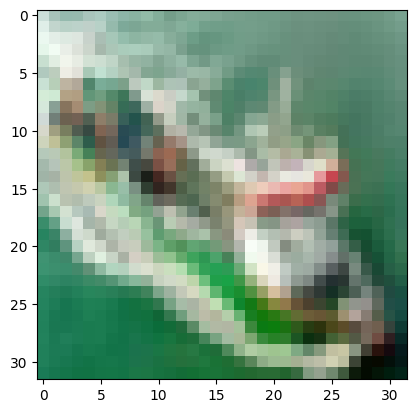

In [52]:
data_number = 15
prueba = X[data_number].detach().numpy().reshape(32, 32, 3)
plt.imshow(prueba, cmap = "gray")

In [53]:
y[data_number]

tensor(8.)

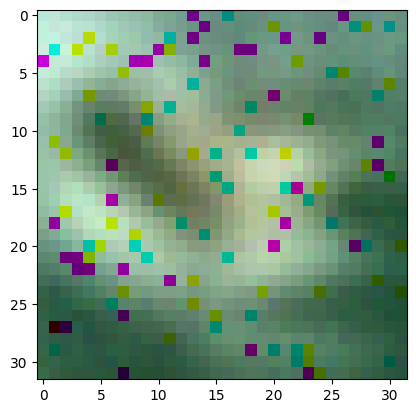

In [54]:
prueba_out = out[data_number].detach().numpy().reshape(32, 32, 3)
plt.imshow(prueba_out, cmap = "gray")

Training a MLP for classification with embeddings of the previous GNN model

In [16]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers, output_size, lr, criterion, use_embeddings = True):
    super().__init__()
    
    self.criterion = criterion
    activation = nn.ReLU()
    self.MLP_layers = nn.ModuleList()
    layer = nn.Linear(input_size, hidden_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(activation)
    self.use_embeddings = use_embeddings

    for _ in range(num_hidden_layers - 1):

      layer = nn.Linear(hidden_size, hidden_size)
      nn.init.xavier_uniform(layer.weight)
      layer.bias.data.fill_(0.01)
      self.MLP_layers.append(layer)
      self.MLP_layers.append(activation)

    layer = nn.Linear(hidden_size, output_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(nn.Sigmoid())

    self.optimizer = Adam(self.parameters(), lr)

  def forward(self, x):
    for layer in self.MLP_layers:
      x = layer(x)

    return x
  
  def train_model(self, train_loader):

    self.train()

    epoch_losses = []
    epoch_accuracies = []

    for X, y in tqdm(train_loader):

      self.optimizer.zero_grad()
      if self.use_embeddings:
        with torch.no_grad():
          Z = model.encode(X)
        out = self.forward(Z)
      else:
        out = self.forward(X)
      
      loss = self.criterion(out, y.long())
      preds = torch.argmax(out, dim = 1)
      accuracy = torch.mean((preds == y.long()).float())
      epoch_losses.append(loss)
      epoch_accuracies.append(accuracy)
      loss.backward()
      self.optimizer.step()

    avg_loss = torch.mean(torch.Tensor(epoch_losses))
    avg_accuracy = torch.mean(torch.Tensor(epoch_accuracies))

    return avg_loss.item(), avg_accuracy.item()
  
  def test_model(self, data_loader):

    self.eval()

    test_losses = []
    test_accuracies = []

    for X, y in tqdm(data_loader):
        if self.use_embeddings:
          with torch.no_grad():
            Z = model.encode(X)
          out = self.forward(Z)
        else:
          out = self.forward(X)
        
        loss = self.criterion(out, y.long())
        preds = torch.argmax(out, dim = 1)
        accuracy = torch.mean((preds == y.long()).float())
        test_losses.append(loss)
        test_accuracies.append(accuracy)
    avg_loss = torch.mean(torch.Tensor(test_losses))
    avg_accuracy = torch.mean(torch.Tensor(test_accuracies))

    return avg_loss.item(), avg_accuracy.item()


In [17]:
lr_classif = 0.001
loss = nn.CrossEntropyLoss()
classif = MLP(latent_size, 64, 1, 10, lr_classif, loss, use_embeddings = True)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_32236\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_32236\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [97]:
classif.parameters

<bound method Module.parameters of MLP(
  (criterion): CrossEntropyLoss()
  (MLP_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): Sigmoid()
  )
)>

In [18]:
epochs_classif = 200

In [19]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 20/20 [00:00<00:00, 61.86it/s]


avg_loss_train: 2.2126, avg_accuracy_train: 0.2135
avg_loss_val: 2.1479, avg_accuracy_val: 0.2833
epoch: 2/200


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 2.1104, avg_accuracy_train: 0.3061
avg_loss_val: 2.0911, avg_accuracy_val: 0.3203
epoch: 3/200


100%|██████████| 20/20 [00:00<00:00, 74.56it/s]


avg_loss_train: 2.0688, avg_accuracy_train: 0.3318
avg_loss_val: 2.0638, avg_accuracy_val: 0.3250
epoch: 4/200


100%|██████████| 20/20 [00:00<00:00, 78.05it/s]


avg_loss_train: 2.0478, avg_accuracy_train: 0.3415
avg_loss_val: 2.0485, avg_accuracy_val: 0.3414
epoch: 5/200


100%|██████████| 20/20 [00:00<00:00, 76.27it/s]


avg_loss_train: 2.0338, avg_accuracy_train: 0.3500
avg_loss_val: 2.0367, avg_accuracy_val: 0.3409
epoch: 6/200


100%|██████████| 20/20 [00:00<00:00, 65.51it/s]


avg_loss_train: 2.0246, avg_accuracy_train: 0.3531
avg_loss_val: 2.0295, avg_accuracy_val: 0.3438
epoch: 7/200


100%|██████████| 20/20 [00:00<00:00, 74.01it/s]


avg_loss_train: 2.0167, avg_accuracy_train: 0.3599
avg_loss_val: 2.0248, avg_accuracy_val: 0.3509
epoch: 8/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 2.0099, avg_accuracy_train: 0.3653
avg_loss_val: 2.0157, avg_accuracy_val: 0.3571
epoch: 9/200


100%|██████████| 20/20 [00:00<00:00, 72.14it/s]


avg_loss_train: 2.0032, avg_accuracy_train: 0.3695
avg_loss_val: 2.0131, avg_accuracy_val: 0.3645
epoch: 10/200


100%|██████████| 20/20 [00:00<00:00, 72.66it/s]


avg_loss_train: 1.9981, avg_accuracy_train: 0.3736
avg_loss_val: 2.0060, avg_accuracy_val: 0.3649
epoch: 11/200


100%|██████████| 20/20 [00:00<00:00, 76.85it/s]


avg_loss_train: 1.9926, avg_accuracy_train: 0.3787
avg_loss_val: 2.0041, avg_accuracy_val: 0.3673
epoch: 12/200


100%|██████████| 20/20 [00:00<00:00, 61.48it/s]


avg_loss_train: 1.9881, avg_accuracy_train: 0.3779
avg_loss_val: 1.9987, avg_accuracy_val: 0.3755
epoch: 13/200


100%|██████████| 20/20 [00:00<00:00, 70.11it/s]


avg_loss_train: 1.9845, avg_accuracy_train: 0.3804
avg_loss_val: 1.9965, avg_accuracy_val: 0.3706
epoch: 14/200


100%|██████████| 20/20 [00:00<00:00, 74.10it/s]


avg_loss_train: 1.9809, avg_accuracy_train: 0.3834
avg_loss_val: 1.9910, avg_accuracy_val: 0.3718
epoch: 15/200


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 1.9776, avg_accuracy_train: 0.3841
avg_loss_val: 1.9868, avg_accuracy_val: 0.3816
epoch: 16/200


100%|██████████| 20/20 [00:00<00:00, 74.56it/s]


avg_loss_train: 1.9739, avg_accuracy_train: 0.3882
avg_loss_val: 1.9830, avg_accuracy_val: 0.3847
epoch: 17/200


100%|██████████| 20/20 [00:00<00:00, 71.45it/s]


avg_loss_train: 1.9712, avg_accuracy_train: 0.3895
avg_loss_val: 1.9813, avg_accuracy_val: 0.3801
epoch: 18/200


100%|██████████| 20/20 [00:00<00:00, 74.28it/s]


avg_loss_train: 1.9678, avg_accuracy_train: 0.3911
avg_loss_val: 1.9780, avg_accuracy_val: 0.3886
epoch: 19/200


100%|██████████| 20/20 [00:00<00:00, 74.42it/s]


avg_loss_train: 1.9642, avg_accuracy_train: 0.3965
avg_loss_val: 1.9750, avg_accuracy_val: 0.3800
epoch: 20/200


100%|██████████| 20/20 [00:00<00:00, 73.80it/s]


avg_loss_train: 1.9627, avg_accuracy_train: 0.3956
avg_loss_val: 1.9741, avg_accuracy_val: 0.3834
epoch: 21/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.9588, avg_accuracy_train: 0.3990
avg_loss_val: 1.9720, avg_accuracy_val: 0.3876
epoch: 22/200


100%|██████████| 20/20 [00:00<00:00, 71.21it/s]


avg_loss_train: 1.9566, avg_accuracy_train: 0.3998
avg_loss_val: 1.9710, avg_accuracy_val: 0.3816
epoch: 23/200


100%|██████████| 20/20 [00:00<00:00, 72.40it/s]


avg_loss_train: 1.9546, avg_accuracy_train: 0.4002
avg_loss_val: 1.9646, avg_accuracy_val: 0.3939
epoch: 24/200


100%|██████████| 20/20 [00:00<00:00, 75.98it/s]


avg_loss_train: 1.9518, avg_accuracy_train: 0.4045
avg_loss_val: 1.9646, avg_accuracy_val: 0.3975
epoch: 25/200


100%|██████████| 20/20 [00:00<00:00, 74.84it/s]


avg_loss_train: 1.9493, avg_accuracy_train: 0.4031
avg_loss_val: 1.9631, avg_accuracy_val: 0.3957
epoch: 26/200


100%|██████████| 20/20 [00:00<00:00, 73.73it/s]


avg_loss_train: 1.9470, avg_accuracy_train: 0.4058
avg_loss_val: 1.9633, avg_accuracy_val: 0.3928
epoch: 27/200


100%|██████████| 20/20 [00:00<00:00, 72.40it/s]


avg_loss_train: 1.9457, avg_accuracy_train: 0.4086
avg_loss_val: 1.9624, avg_accuracy_val: 0.4001
epoch: 28/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.9437, avg_accuracy_train: 0.4089
avg_loss_val: 1.9582, avg_accuracy_val: 0.3952
epoch: 29/200


100%|██████████| 20/20 [00:00<00:00, 73.46it/s]


avg_loss_train: 1.9422, avg_accuracy_train: 0.4108
avg_loss_val: 1.9552, avg_accuracy_val: 0.4052
epoch: 30/200


100%|██████████| 20/20 [00:00<00:00, 76.85it/s]


avg_loss_train: 1.9397, avg_accuracy_train: 0.4128
avg_loss_val: 1.9560, avg_accuracy_val: 0.4029
epoch: 31/200


100%|██████████| 20/20 [00:00<00:00, 70.95it/s]


avg_loss_train: 1.9388, avg_accuracy_train: 0.4135
avg_loss_val: 1.9549, avg_accuracy_val: 0.3989
epoch: 32/200


100%|██████████| 20/20 [00:00<00:00, 73.46it/s]


avg_loss_train: 1.9369, avg_accuracy_train: 0.4128
avg_loss_val: 1.9535, avg_accuracy_val: 0.3998
epoch: 33/200


100%|██████████| 20/20 [00:00<00:00, 76.85it/s]


avg_loss_train: 1.9364, avg_accuracy_train: 0.4129
avg_loss_val: 1.9540, avg_accuracy_val: 0.4045
epoch: 34/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.9348, avg_accuracy_train: 0.4142
avg_loss_val: 1.9504, avg_accuracy_val: 0.4040
epoch: 35/200


100%|██████████| 20/20 [00:00<00:00, 75.69it/s]


avg_loss_train: 1.9326, avg_accuracy_train: 0.4160
avg_loss_val: 1.9503, avg_accuracy_val: 0.4115
epoch: 36/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.9314, avg_accuracy_train: 0.4161
avg_loss_val: 1.9516, avg_accuracy_val: 0.3987
epoch: 37/200


100%|██████████| 20/20 [00:00<00:00, 71.88it/s]


avg_loss_train: 1.9306, avg_accuracy_train: 0.4168
avg_loss_val: 1.9464, avg_accuracy_val: 0.4040
epoch: 38/200


100%|██████████| 20/20 [00:00<00:00, 70.61it/s]


avg_loss_train: 1.9295, avg_accuracy_train: 0.4159
avg_loss_val: 1.9479, avg_accuracy_val: 0.4015
epoch: 39/200


100%|██████████| 20/20 [00:00<00:00, 67.54it/s]


avg_loss_train: 1.9281, avg_accuracy_train: 0.4194
avg_loss_val: 1.9477, avg_accuracy_val: 0.4055
epoch: 40/200


100%|██████████| 20/20 [00:00<00:00, 74.84it/s]


avg_loss_train: 1.9265, avg_accuracy_train: 0.4186
avg_loss_val: 1.9422, avg_accuracy_val: 0.4085
epoch: 41/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.9254, avg_accuracy_train: 0.4210
avg_loss_val: 1.9417, avg_accuracy_val: 0.4098
epoch: 42/200


100%|██████████| 20/20 [00:00<00:00, 74.77it/s]


avg_loss_train: 1.9247, avg_accuracy_train: 0.4210
avg_loss_val: 1.9432, avg_accuracy_val: 0.4111
epoch: 43/200


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 1.9239, avg_accuracy_train: 0.4217
avg_loss_val: 1.9448, avg_accuracy_val: 0.4021
epoch: 44/200


100%|██████████| 20/20 [00:00<00:00, 69.62it/s]


avg_loss_train: 1.9237, avg_accuracy_train: 0.4208
avg_loss_val: 1.9432, avg_accuracy_val: 0.4101
epoch: 45/200


100%|██████████| 20/20 [00:00<00:00, 76.56it/s]


avg_loss_train: 1.9228, avg_accuracy_train: 0.4218
avg_loss_val: 1.9416, avg_accuracy_val: 0.4053
epoch: 46/200


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 1.9214, avg_accuracy_train: 0.4225
avg_loss_val: 1.9394, avg_accuracy_val: 0.4103
epoch: 47/200


100%|██████████| 20/20 [00:00<00:00, 74.56it/s]


avg_loss_train: 1.9207, avg_accuracy_train: 0.4230
avg_loss_val: 1.9423, avg_accuracy_val: 0.4144
epoch: 48/200


100%|██████████| 20/20 [00:00<00:00, 70.11it/s]


avg_loss_train: 1.9197, avg_accuracy_train: 0.4237
avg_loss_val: 1.9385, avg_accuracy_val: 0.4103
epoch: 49/200


100%|██████████| 20/20 [00:00<00:00, 74.60it/s]


avg_loss_train: 1.9196, avg_accuracy_train: 0.4242
avg_loss_val: 1.9415, avg_accuracy_val: 0.4110
epoch: 50/200


100%|██████████| 20/20 [00:00<00:00, 75.69it/s]


avg_loss_train: 1.9174, avg_accuracy_train: 0.4238
avg_loss_val: 1.9401, avg_accuracy_val: 0.4129
epoch: 51/200


100%|██████████| 20/20 [00:00<00:00, 74.01it/s]


avg_loss_train: 1.9174, avg_accuracy_train: 0.4246
avg_loss_val: 1.9349, avg_accuracy_val: 0.4152
epoch: 52/200


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 1.9163, avg_accuracy_train: 0.4247
avg_loss_val: 1.9371, avg_accuracy_val: 0.4097
epoch: 53/200


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 1.9156, avg_accuracy_train: 0.4271
avg_loss_val: 1.9365, avg_accuracy_val: 0.4147
epoch: 54/200


100%|██████████| 20/20 [00:00<00:00, 74.56it/s]


avg_loss_train: 1.9151, avg_accuracy_train: 0.4288
avg_loss_val: 1.9352, avg_accuracy_val: 0.4161
epoch: 55/200


100%|██████████| 20/20 [00:00<00:00, 67.05it/s]


avg_loss_train: 1.9146, avg_accuracy_train: 0.4267
avg_loss_val: 1.9394, avg_accuracy_val: 0.4103
epoch: 56/200


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 1.9138, avg_accuracy_train: 0.4279
avg_loss_val: 1.9367, avg_accuracy_val: 0.4160
epoch: 57/200


100%|██████████| 20/20 [00:00<00:00, 74.28it/s]


avg_loss_train: 1.9133, avg_accuracy_train: 0.4274
avg_loss_val: 1.9343, avg_accuracy_val: 0.4204
epoch: 58/200


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 1.9121, avg_accuracy_train: 0.4289
avg_loss_val: 1.9329, avg_accuracy_val: 0.4180
epoch: 59/200


100%|██████████| 20/20 [00:00<00:00, 71.88it/s]


avg_loss_train: 1.9121, avg_accuracy_train: 0.4283
avg_loss_val: 1.9349, avg_accuracy_val: 0.4155
epoch: 60/200


100%|██████████| 20/20 [00:00<00:00, 73.46it/s]


avg_loss_train: 1.9111, avg_accuracy_train: 0.4303
avg_loss_val: 1.9320, avg_accuracy_val: 0.4187
epoch: 61/200


100%|██████████| 20/20 [00:00<00:00, 77.75it/s]


avg_loss_train: 1.9114, avg_accuracy_train: 0.4310
avg_loss_val: 1.9323, avg_accuracy_val: 0.4201
epoch: 62/200


100%|██████████| 20/20 [00:00<00:00, 72.66it/s]


avg_loss_train: 1.9105, avg_accuracy_train: 0.4299
avg_loss_val: 1.9330, avg_accuracy_val: 0.4175
epoch: 63/200


100%|██████████| 20/20 [00:00<00:00, 62.84it/s]


avg_loss_train: 1.9096, avg_accuracy_train: 0.4312
avg_loss_val: 1.9305, avg_accuracy_val: 0.4201
epoch: 64/200


100%|██████████| 20/20 [00:00<00:00, 77.38it/s]


avg_loss_train: 1.9093, avg_accuracy_train: 0.4298
avg_loss_val: 1.9315, avg_accuracy_val: 0.4166
epoch: 65/200


100%|██████████| 20/20 [00:00<00:00, 68.20it/s]


avg_loss_train: 1.9080, avg_accuracy_train: 0.4325
avg_loss_val: 1.9298, avg_accuracy_val: 0.4252
epoch: 66/200


100%|██████████| 20/20 [00:00<00:00, 69.38it/s]


avg_loss_train: 1.9074, avg_accuracy_train: 0.4322
avg_loss_val: 1.9300, avg_accuracy_val: 0.4200
epoch: 67/200


100%|██████████| 20/20 [00:00<00:00, 66.83it/s]


avg_loss_train: 1.9074, avg_accuracy_train: 0.4315
avg_loss_val: 1.9277, avg_accuracy_val: 0.4224
epoch: 68/200


100%|██████████| 20/20 [00:00<00:00, 67.74it/s]


avg_loss_train: 1.9076, avg_accuracy_train: 0.4301
avg_loss_val: 1.9315, avg_accuracy_val: 0.4201
epoch: 69/200


100%|██████████| 20/20 [00:00<00:00, 70.61it/s]


avg_loss_train: 1.9061, avg_accuracy_train: 0.4329
avg_loss_val: 1.9266, avg_accuracy_val: 0.4232
epoch: 70/200


100%|██████████| 20/20 [00:00<00:00, 69.62it/s]


avg_loss_train: 1.9066, avg_accuracy_train: 0.4338
avg_loss_val: 1.9306, avg_accuracy_val: 0.4209
epoch: 71/200


100%|██████████| 20/20 [00:00<00:00, 71.62it/s]


avg_loss_train: 1.9056, avg_accuracy_train: 0.4332
avg_loss_val: 1.9298, avg_accuracy_val: 0.4185
epoch: 72/200


100%|██████████| 20/20 [00:00<00:00, 75.97it/s]


avg_loss_train: 1.9052, avg_accuracy_train: 0.4348
avg_loss_val: 1.9263, avg_accuracy_val: 0.4230
epoch: 73/200


100%|██████████| 20/20 [00:00<00:00, 74.28it/s]


avg_loss_train: 1.9053, avg_accuracy_train: 0.4340
avg_loss_val: 1.9277, avg_accuracy_val: 0.4157
epoch: 74/200


100%|██████████| 20/20 [00:00<00:00, 69.87it/s]


avg_loss_train: 1.9039, avg_accuracy_train: 0.4341
avg_loss_val: 1.9279, avg_accuracy_val: 0.4204
epoch: 75/200


100%|██████████| 20/20 [00:00<00:00, 70.11it/s]


avg_loss_train: 1.9035, avg_accuracy_train: 0.4353
avg_loss_val: 1.9266, avg_accuracy_val: 0.4248
epoch: 76/200


100%|██████████| 20/20 [00:00<00:00, 72.66it/s]


avg_loss_train: 1.9028, avg_accuracy_train: 0.4353
avg_loss_val: 1.9262, avg_accuracy_val: 0.4242
epoch: 77/200


100%|██████████| 20/20 [00:00<00:00, 58.87it/s]


avg_loss_train: 1.9024, avg_accuracy_train: 0.4355
avg_loss_val: 1.9263, avg_accuracy_val: 0.4311
epoch: 78/200


100%|██████████| 20/20 [00:00<00:00, 77.45it/s]


avg_loss_train: 1.9018, avg_accuracy_train: 0.4364
avg_loss_val: 1.9271, avg_accuracy_val: 0.4276
epoch: 79/200


100%|██████████| 20/20 [00:00<00:00, 69.87it/s]


avg_loss_train: 1.9022, avg_accuracy_train: 0.4375
avg_loss_val: 1.9263, avg_accuracy_val: 0.4265
epoch: 80/200


100%|██████████| 20/20 [00:00<00:00, 75.15it/s]


avg_loss_train: 1.9013, avg_accuracy_train: 0.4369
avg_loss_val: 1.9297, avg_accuracy_val: 0.4154
epoch: 81/200


100%|██████████| 20/20 [00:00<00:00, 66.83it/s]


avg_loss_train: 1.9007, avg_accuracy_train: 0.4375
avg_loss_val: 1.9255, avg_accuracy_val: 0.4307
epoch: 82/200


100%|██████████| 20/20 [00:00<00:00, 72.71it/s]


avg_loss_train: 1.8997, avg_accuracy_train: 0.4400
avg_loss_val: 1.9271, avg_accuracy_val: 0.4227
epoch: 83/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.9001, avg_accuracy_train: 0.4378
avg_loss_val: 1.9237, avg_accuracy_val: 0.4255
epoch: 84/200


100%|██████████| 20/20 [00:00<00:00, 69.14it/s]


avg_loss_train: 1.8997, avg_accuracy_train: 0.4372
avg_loss_val: 1.9263, avg_accuracy_val: 0.4199
epoch: 85/200


100%|██████████| 20/20 [00:00<00:00, 74.56it/s]


avg_loss_train: 1.9000, avg_accuracy_train: 0.4391
avg_loss_val: 1.9280, avg_accuracy_val: 0.4194
epoch: 86/200


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 1.8994, avg_accuracy_train: 0.4370
avg_loss_val: 1.9217, avg_accuracy_val: 0.4229
epoch: 87/200


100%|██████████| 20/20 [00:00<00:00, 72.14it/s]


avg_loss_train: 1.8990, avg_accuracy_train: 0.4387
avg_loss_val: 1.9238, avg_accuracy_val: 0.4201
epoch: 88/200


100%|██████████| 20/20 [00:00<00:00, 72.14it/s]


avg_loss_train: 1.8973, avg_accuracy_train: 0.4382
avg_loss_val: 1.9287, avg_accuracy_val: 0.4201
epoch: 89/200


100%|██████████| 20/20 [00:00<00:00, 72.14it/s]


avg_loss_train: 1.8974, avg_accuracy_train: 0.4392
avg_loss_val: 1.9269, avg_accuracy_val: 0.4247
epoch: 90/200


100%|██████████| 20/20 [00:00<00:00, 73.76it/s]


avg_loss_train: 1.8972, avg_accuracy_train: 0.4390
avg_loss_val: 1.9224, avg_accuracy_val: 0.4251
epoch: 91/200


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 1.8973, avg_accuracy_train: 0.4407
avg_loss_val: 1.9226, avg_accuracy_val: 0.4228
epoch: 92/200


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 1.8966, avg_accuracy_train: 0.4393
avg_loss_val: 1.9232, avg_accuracy_val: 0.4293
epoch: 93/200


100%|██████████| 20/20 [00:00<00:00, 76.56it/s]


avg_loss_train: 1.8956, avg_accuracy_train: 0.4406
avg_loss_val: 1.9250, avg_accuracy_val: 0.4280
epoch: 94/200


100%|██████████| 20/20 [00:00<00:00, 67.28it/s]


avg_loss_train: 1.8960, avg_accuracy_train: 0.4400
avg_loss_val: 1.9244, avg_accuracy_val: 0.4184
epoch: 95/200


100%|██████████| 20/20 [00:00<00:00, 65.84it/s]


avg_loss_train: 1.8955, avg_accuracy_train: 0.4419
avg_loss_val: 1.9217, avg_accuracy_val: 0.4261
epoch: 96/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.8949, avg_accuracy_train: 0.4411
avg_loss_val: 1.9201, avg_accuracy_val: 0.4299
epoch: 97/200


100%|██████████| 20/20 [00:00<00:00, 75.12it/s]


avg_loss_train: 1.8943, avg_accuracy_train: 0.4424
avg_loss_val: 1.9203, avg_accuracy_val: 0.4261
epoch: 98/200


100%|██████████| 20/20 [00:00<00:00, 73.73it/s]


avg_loss_train: 1.8956, avg_accuracy_train: 0.4407
avg_loss_val: 1.9213, avg_accuracy_val: 0.4271
epoch: 99/200


100%|██████████| 20/20 [00:00<00:00, 74.84it/s]


avg_loss_train: 1.8946, avg_accuracy_train: 0.4407
avg_loss_val: 1.9213, avg_accuracy_val: 0.4279
epoch: 100/200


100%|██████████| 20/20 [00:00<00:00, 72.40it/s]


avg_loss_train: 1.8937, avg_accuracy_train: 0.4430
avg_loss_val: 1.9212, avg_accuracy_val: 0.4285
epoch: 101/200


100%|██████████| 20/20 [00:00<00:00, 69.57it/s]


avg_loss_train: 1.8927, avg_accuracy_train: 0.4435
avg_loss_val: 1.9192, avg_accuracy_val: 0.4244
epoch: 102/200


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 1.8924, avg_accuracy_train: 0.4451
avg_loss_val: 1.9192, avg_accuracy_val: 0.4307
epoch: 103/200


100%|██████████| 20/20 [00:00<00:00, 77.15it/s]


avg_loss_train: 1.8933, avg_accuracy_train: 0.4443
avg_loss_val: 1.9187, avg_accuracy_val: 0.4331
epoch: 104/200


100%|██████████| 20/20 [00:00<00:00, 74.28it/s]


avg_loss_train: 1.8921, avg_accuracy_train: 0.4457
avg_loss_val: 1.9207, avg_accuracy_val: 0.4262
epoch: 105/200


100%|██████████| 20/20 [00:00<00:00, 69.87it/s]


avg_loss_train: 1.8917, avg_accuracy_train: 0.4445
avg_loss_val: 1.9177, avg_accuracy_val: 0.4333
epoch: 106/200


100%|██████████| 20/20 [00:00<00:00, 65.57it/s]


avg_loss_train: 1.8911, avg_accuracy_train: 0.4443
avg_loss_val: 1.9193, avg_accuracy_val: 0.4307
epoch: 107/200


100%|██████████| 20/20 [00:00<00:00, 50.46it/s]


avg_loss_train: 1.8908, avg_accuracy_train: 0.4450
avg_loss_val: 1.9180, avg_accuracy_val: 0.4311
epoch: 108/200


100%|██████████| 20/20 [00:00<00:00, 66.16it/s]


avg_loss_train: 1.8906, avg_accuracy_train: 0.4450
avg_loss_val: 1.9179, avg_accuracy_val: 0.4327
epoch: 109/200


100%|██████████| 20/20 [00:00<00:00, 66.38it/s]


avg_loss_train: 1.8907, avg_accuracy_train: 0.4431
avg_loss_val: 1.9166, avg_accuracy_val: 0.4333
epoch: 110/200


100%|██████████| 20/20 [00:00<00:00, 57.50it/s]


avg_loss_train: 1.8901, avg_accuracy_train: 0.4421
avg_loss_val: 1.9207, avg_accuracy_val: 0.4281
epoch: 111/200


100%|██████████| 20/20 [00:00<00:00, 66.83it/s]


avg_loss_train: 1.8900, avg_accuracy_train: 0.4459
avg_loss_val: 1.9187, avg_accuracy_val: 0.4249
epoch: 112/200


100%|██████████| 20/20 [00:00<00:00, 69.14it/s]


avg_loss_train: 1.8898, avg_accuracy_train: 0.4458
avg_loss_val: 1.9165, avg_accuracy_val: 0.4294
epoch: 113/200


100%|██████████| 20/20 [00:00<00:00, 66.29it/s]


avg_loss_train: 1.8883, avg_accuracy_train: 0.4458
avg_loss_val: 1.9196, avg_accuracy_val: 0.4245
epoch: 114/200


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 1.8888, avg_accuracy_train: 0.4453
avg_loss_val: 1.9166, avg_accuracy_val: 0.4304
epoch: 115/200


100%|██████████| 20/20 [00:00<00:00, 74.06it/s]


avg_loss_train: 1.8886, avg_accuracy_train: 0.4454
avg_loss_val: 1.9175, avg_accuracy_val: 0.4357
epoch: 116/200


100%|██████████| 20/20 [00:00<00:00, 72.66it/s]


avg_loss_train: 1.8892, avg_accuracy_train: 0.4458
avg_loss_val: 1.9199, avg_accuracy_val: 0.4295
epoch: 117/200


100%|██████████| 20/20 [00:00<00:00, 75.12it/s]


avg_loss_train: 1.8872, avg_accuracy_train: 0.4479
avg_loss_val: 1.9162, avg_accuracy_val: 0.4301
epoch: 118/200


100%|██████████| 20/20 [00:00<00:00, 72.14it/s]


avg_loss_train: 1.8880, avg_accuracy_train: 0.4462
avg_loss_val: 1.9187, avg_accuracy_val: 0.4311
epoch: 119/200


100%|██████████| 20/20 [00:00<00:00, 65.95it/s]


avg_loss_train: 1.8870, avg_accuracy_train: 0.4470
avg_loss_val: 1.9124, avg_accuracy_val: 0.4346
epoch: 120/200


100%|██████████| 20/20 [00:00<00:00, 72.27it/s]


avg_loss_train: 1.8871, avg_accuracy_train: 0.4457
avg_loss_val: 1.9146, avg_accuracy_val: 0.4309
epoch: 121/200


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 1.8869, avg_accuracy_train: 0.4488
avg_loss_val: 1.9167, avg_accuracy_val: 0.4311
epoch: 122/200


100%|██████████| 20/20 [00:00<00:00, 71.49it/s]


avg_loss_train: 1.8865, avg_accuracy_train: 0.4487
avg_loss_val: 1.9194, avg_accuracy_val: 0.4255
epoch: 123/200


100%|██████████| 20/20 [00:00<00:00, 70.61it/s]


avg_loss_train: 1.8864, avg_accuracy_train: 0.4476
avg_loss_val: 1.9207, avg_accuracy_val: 0.4226
epoch: 124/200


100%|██████████| 20/20 [00:00<00:00, 70.86it/s]


avg_loss_train: 1.8856, avg_accuracy_train: 0.4479
avg_loss_val: 1.9137, avg_accuracy_val: 0.4341
epoch: 125/200


100%|██████████| 20/20 [00:00<00:00, 69.69it/s]


avg_loss_train: 1.8859, avg_accuracy_train: 0.4487
avg_loss_val: 1.9168, avg_accuracy_val: 0.4309
epoch: 126/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.8851, avg_accuracy_train: 0.4493
avg_loss_val: 1.9144, avg_accuracy_val: 0.4310
epoch: 127/200


100%|██████████| 20/20 [00:00<00:00, 68.83it/s]


avg_loss_train: 1.8840, avg_accuracy_train: 0.4475
avg_loss_val: 1.9132, avg_accuracy_val: 0.4352
epoch: 128/200


100%|██████████| 20/20 [00:00<00:00, 68.20it/s]


avg_loss_train: 1.8854, avg_accuracy_train: 0.4486
avg_loss_val: 1.9143, avg_accuracy_val: 0.4351
epoch: 129/200


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 1.8836, avg_accuracy_train: 0.4499
avg_loss_val: 1.9170, avg_accuracy_val: 0.4347
epoch: 130/200


100%|██████████| 20/20 [00:00<00:00, 75.12it/s]


avg_loss_train: 1.8842, avg_accuracy_train: 0.4497
avg_loss_val: 1.9134, avg_accuracy_val: 0.4345
epoch: 131/200


100%|██████████| 20/20 [00:00<00:00, 74.01it/s]


avg_loss_train: 1.8840, avg_accuracy_train: 0.4487
avg_loss_val: 1.9217, avg_accuracy_val: 0.4243
epoch: 132/200


100%|██████████| 20/20 [00:00<00:00, 69.62it/s]


avg_loss_train: 1.8850, avg_accuracy_train: 0.4491
avg_loss_val: 1.9130, avg_accuracy_val: 0.4345
epoch: 133/200


100%|██████████| 20/20 [00:00<00:00, 71.88it/s]


avg_loss_train: 1.8838, avg_accuracy_train: 0.4500
avg_loss_val: 1.9177, avg_accuracy_val: 0.4214
epoch: 134/200


100%|██████████| 20/20 [00:00<00:00, 73.46it/s]


avg_loss_train: 1.8831, avg_accuracy_train: 0.4496
avg_loss_val: 1.9139, avg_accuracy_val: 0.4387
epoch: 135/200


100%|██████████| 20/20 [00:00<00:00, 72.66it/s]


avg_loss_train: 1.8834, avg_accuracy_train: 0.4491
avg_loss_val: 1.9111, avg_accuracy_val: 0.4348
epoch: 136/200


100%|██████████| 20/20 [00:00<00:00, 75.43it/s]


avg_loss_train: 1.8820, avg_accuracy_train: 0.4508
avg_loss_val: 1.9162, avg_accuracy_val: 0.4327
epoch: 137/200


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 1.8831, avg_accuracy_train: 0.4494
avg_loss_val: 1.9124, avg_accuracy_val: 0.4396
epoch: 138/200


100%|██████████| 20/20 [00:00<00:00, 76.56it/s]


avg_loss_train: 1.8822, avg_accuracy_train: 0.4506
avg_loss_val: 1.9149, avg_accuracy_val: 0.4359
epoch: 139/200


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 1.8813, avg_accuracy_train: 0.4542
avg_loss_val: 1.9135, avg_accuracy_val: 0.4301
epoch: 140/200


100%|██████████| 20/20 [00:00<00:00, 71.11it/s]


avg_loss_train: 1.8815, avg_accuracy_train: 0.4516
avg_loss_val: 1.9150, avg_accuracy_val: 0.4332
epoch: 141/200


100%|██████████| 20/20 [00:00<00:00, 74.28it/s]


avg_loss_train: 1.8808, avg_accuracy_train: 0.4503
avg_loss_val: 1.9134, avg_accuracy_val: 0.4275
epoch: 142/200


100%|██████████| 20/20 [00:00<00:00, 75.12it/s]


avg_loss_train: 1.8812, avg_accuracy_train: 0.4515
avg_loss_val: 1.9182, avg_accuracy_val: 0.4289
epoch: 143/200


100%|██████████| 20/20 [00:00<00:00, 69.62it/s]


avg_loss_train: 1.8817, avg_accuracy_train: 0.4500
avg_loss_val: 1.9122, avg_accuracy_val: 0.4387
epoch: 144/200


100%|██████████| 20/20 [00:00<00:00, 72.40it/s]


avg_loss_train: 1.8805, avg_accuracy_train: 0.4518
avg_loss_val: 1.9158, avg_accuracy_val: 0.4329
epoch: 145/200


100%|██████████| 20/20 [00:00<00:00, 77.81it/s]


avg_loss_train: 1.8805, avg_accuracy_train: 0.4531
avg_loss_val: 1.9140, avg_accuracy_val: 0.4349
epoch: 146/200


100%|██████████| 20/20 [00:00<00:00, 72.93it/s]


avg_loss_train: 1.8803, avg_accuracy_train: 0.4519
avg_loss_val: 1.9132, avg_accuracy_val: 0.4338
epoch: 147/200


100%|██████████| 20/20 [00:00<00:00, 74.84it/s]


avg_loss_train: 1.8805, avg_accuracy_train: 0.4515
avg_loss_val: 1.9178, avg_accuracy_val: 0.4369
epoch: 148/200


100%|██████████| 20/20 [00:00<00:00, 73.73it/s]


avg_loss_train: 1.8803, avg_accuracy_train: 0.4533
avg_loss_val: 1.9088, avg_accuracy_val: 0.4428
epoch: 149/200


100%|██████████| 20/20 [00:00<00:00, 69.14it/s]


avg_loss_train: 1.8796, avg_accuracy_train: 0.4542
avg_loss_val: 1.9120, avg_accuracy_val: 0.4336
epoch: 150/200


100%|██████████| 20/20 [00:00<00:00, 74.38it/s]


avg_loss_train: 1.8788, avg_accuracy_train: 0.4529
avg_loss_val: 1.9153, avg_accuracy_val: 0.4341
epoch: 151/200


100%|██████████| 20/20 [00:00<00:00, 70.86it/s]


avg_loss_train: 1.8790, avg_accuracy_train: 0.4544
avg_loss_val: 1.9126, avg_accuracy_val: 0.4379
epoch: 152/200


100%|██████████| 20/20 [00:00<00:00, 75.12it/s]


avg_loss_train: 1.8788, avg_accuracy_train: 0.4524
avg_loss_val: 1.9161, avg_accuracy_val: 0.4287
epoch: 153/200


100%|██████████| 20/20 [00:00<00:00, 64.46it/s]


avg_loss_train: 1.8794, avg_accuracy_train: 0.4536
avg_loss_val: 1.9110, avg_accuracy_val: 0.4327
epoch: 154/200


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 1.8790, avg_accuracy_train: 0.4532
avg_loss_val: 1.9145, avg_accuracy_val: 0.4428
epoch: 155/200


100%|██████████| 20/20 [00:00<00:00, 74.28it/s]


avg_loss_train: 1.8788, avg_accuracy_train: 0.4539
avg_loss_val: 1.9106, avg_accuracy_val: 0.4387
epoch: 156/200


100%|██████████| 20/20 [00:00<00:00, 78.67it/s]


avg_loss_train: 1.8780, avg_accuracy_train: 0.4552
avg_loss_val: 1.9118, avg_accuracy_val: 0.4392
epoch: 157/200


100%|██████████| 20/20 [00:00<00:00, 64.59it/s]


avg_loss_train: 1.8787, avg_accuracy_train: 0.4532
avg_loss_val: 1.9176, avg_accuracy_val: 0.4354
epoch: 158/200


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 1.8784, avg_accuracy_train: 0.4526
avg_loss_val: 1.9162, avg_accuracy_val: 0.4369
epoch: 159/200


100%|██████████| 20/20 [00:00<00:00, 65.09it/s]


avg_loss_train: 1.8768, avg_accuracy_train: 0.4543
avg_loss_val: 1.9130, avg_accuracy_val: 0.4420
epoch: 160/200


100%|██████████| 20/20 [00:00<00:00, 66.83it/s]


avg_loss_train: 1.8777, avg_accuracy_train: 0.4544
avg_loss_val: 1.9129, avg_accuracy_val: 0.4370
epoch: 161/200


100%|██████████| 20/20 [00:00<00:00, 73.01it/s]


avg_loss_train: 1.8777, avg_accuracy_train: 0.4529
avg_loss_val: 1.9144, avg_accuracy_val: 0.4334
epoch: 162/200


100%|██████████| 20/20 [00:00<00:00, 70.61it/s]


avg_loss_train: 1.8769, avg_accuracy_train: 0.4544
avg_loss_val: 1.9118, avg_accuracy_val: 0.4357
epoch: 163/200


100%|██████████| 20/20 [00:00<00:00, 73.32it/s]


avg_loss_train: 1.8769, avg_accuracy_train: 0.4554
avg_loss_val: 1.9081, avg_accuracy_val: 0.4442
epoch: 164/200


 20%|█▉        | 35/176 [00:00<00:02, 54.19it/s]


KeyboardInterrupt: 

In [20]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 40/40 [00:00<00:00, 96.13it/s]

avg_loss_test: 1.8981, avg_accuracy_test: 0.4454


Comparing with MLP trained on input images

In [27]:
classif_inputs = MLP(input_size, 64, 1, 10, lr_classif, loss, use_embeddings = False)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_32236\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_32236\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [28]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif_inputs.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif_inputs.test_model(val_loader)
    
    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 20/20 [00:00<00:00, 99.41it/s] 


avg_loss_train: 2.0972, avg_accuracy_train: 0.2912
avg_loss_val: 2.0589, avg_accuracy_val: 0.3231
epoch: 2/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 2.0339, avg_accuracy_train: 0.3420
avg_loss_val: 2.0304, avg_accuracy_val: 0.3496
epoch: 3/200


100%|██████████| 20/20 [00:00<00:00, 112.51it/s]


avg_loss_train: 2.0119, avg_accuracy_train: 0.3549
avg_loss_val: 2.0118, avg_accuracy_val: 0.3616
epoch: 4/200


100%|██████████| 20/20 [00:00<00:00, 113.53it/s]


avg_loss_train: 1.9965, avg_accuracy_train: 0.3686
avg_loss_val: 2.0004, avg_accuracy_val: 0.3712
epoch: 5/200


100%|██████████| 20/20 [00:00<00:00, 112.89it/s]


avg_loss_train: 1.9848, avg_accuracy_train: 0.3734
avg_loss_val: 1.9963, avg_accuracy_val: 0.3628
epoch: 6/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 1.9737, avg_accuracy_train: 0.3810
avg_loss_val: 1.9927, avg_accuracy_val: 0.3760
epoch: 7/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.9651, avg_accuracy_train: 0.3855
avg_loss_val: 1.9702, avg_accuracy_val: 0.3916
epoch: 8/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.9569, avg_accuracy_train: 0.3920
avg_loss_val: 1.9753, avg_accuracy_val: 0.3836
epoch: 9/200


100%|██████████| 20/20 [00:00<00:00, 110.40it/s]


avg_loss_train: 1.9515, avg_accuracy_train: 0.3964
avg_loss_val: 1.9664, avg_accuracy_val: 0.3841
epoch: 10/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.9463, avg_accuracy_train: 0.4004
avg_loss_val: 1.9669, avg_accuracy_val: 0.3775
epoch: 11/200


100%|██████████| 20/20 [00:00<00:00, 110.98it/s]


avg_loss_train: 1.9413, avg_accuracy_train: 0.4044
avg_loss_val: 1.9564, avg_accuracy_val: 0.3852
epoch: 12/200


100%|██████████| 20/20 [00:00<00:00, 111.63it/s]


avg_loss_train: 1.9336, avg_accuracy_train: 0.4094
avg_loss_val: 1.9575, avg_accuracy_val: 0.3980
epoch: 13/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.9320, avg_accuracy_train: 0.4110
avg_loss_val: 1.9661, avg_accuracy_val: 0.3851
epoch: 14/200


100%|██████████| 20/20 [00:00<00:00, 88.03it/s]


avg_loss_train: 1.9294, avg_accuracy_train: 0.4111
avg_loss_val: 1.9551, avg_accuracy_val: 0.3942
epoch: 15/200


100%|██████████| 20/20 [00:00<00:00, 109.19it/s]


avg_loss_train: 1.9271, avg_accuracy_train: 0.4124
avg_loss_val: 1.9505, avg_accuracy_val: 0.4111
epoch: 16/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.9201, avg_accuracy_train: 0.4202
avg_loss_val: 1.9425, avg_accuracy_val: 0.4060
epoch: 17/200


100%|██████████| 20/20 [00:00<00:00, 112.89it/s]


avg_loss_train: 1.9167, avg_accuracy_train: 0.4215
avg_loss_val: 1.9487, avg_accuracy_val: 0.3978
epoch: 18/200


100%|██████████| 20/20 [00:00<00:00, 96.07it/s]


avg_loss_train: 1.9144, avg_accuracy_train: 0.4236
avg_loss_val: 1.9362, avg_accuracy_val: 0.4117
epoch: 19/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.9115, avg_accuracy_train: 0.4262
avg_loss_val: 1.9388, avg_accuracy_val: 0.4110
epoch: 20/200


100%|██████████| 20/20 [00:00<00:00, 112.39it/s]


avg_loss_train: 1.9073, avg_accuracy_train: 0.4307
avg_loss_val: 1.9346, avg_accuracy_val: 0.4193
epoch: 21/200


100%|██████████| 20/20 [00:00<00:00, 106.85it/s]


avg_loss_train: 1.9075, avg_accuracy_train: 0.4303
avg_loss_val: 1.9338, avg_accuracy_val: 0.4154
epoch: 22/200


100%|██████████| 20/20 [00:00<00:00, 84.91it/s] 


avg_loss_train: 1.9024, avg_accuracy_train: 0.4347
avg_loss_val: 1.9346, avg_accuracy_val: 0.4224
epoch: 23/200


100%|██████████| 20/20 [00:00<00:00, 98.43it/s] 


avg_loss_train: 1.9009, avg_accuracy_train: 0.4352
avg_loss_val: 1.9286, avg_accuracy_val: 0.4211
epoch: 24/200


100%|██████████| 20/20 [00:00<00:00, 98.92it/s]


avg_loss_train: 1.8982, avg_accuracy_train: 0.4406
avg_loss_val: 1.9382, avg_accuracy_val: 0.4092
epoch: 25/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8981, avg_accuracy_train: 0.4380
avg_loss_val: 1.9345, avg_accuracy_val: 0.4238
epoch: 26/200


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 1.8939, avg_accuracy_train: 0.4408
avg_loss_val: 1.9326, avg_accuracy_val: 0.4257
epoch: 27/200


100%|██████████| 20/20 [00:00<00:00, 114.03it/s]


avg_loss_train: 1.8928, avg_accuracy_train: 0.4433
avg_loss_val: 1.9217, avg_accuracy_val: 0.4302
epoch: 28/200


100%|██████████| 20/20 [00:00<00:00, 109.19it/s]


avg_loss_train: 1.8891, avg_accuracy_train: 0.4469
avg_loss_val: 1.9256, avg_accuracy_val: 0.4198
epoch: 29/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8882, avg_accuracy_train: 0.4476
avg_loss_val: 1.9256, avg_accuracy_val: 0.4331
epoch: 30/200


100%|██████████| 20/20 [00:00<00:00, 101.43it/s]


avg_loss_train: 1.8860, avg_accuracy_train: 0.4491
avg_loss_val: 1.9192, avg_accuracy_val: 0.4320
epoch: 31/200


100%|██████████| 20/20 [00:00<00:00, 96.07it/s]


avg_loss_train: 1.8843, avg_accuracy_train: 0.4492
avg_loss_val: 1.9217, avg_accuracy_val: 0.4346
epoch: 32/200


100%|██████████| 20/20 [00:00<00:00, 105.27it/s]


avg_loss_train: 1.8827, avg_accuracy_train: 0.4554
avg_loss_val: 1.9249, avg_accuracy_val: 0.4295
epoch: 33/200


100%|██████████| 20/20 [00:00<00:00, 108.01it/s]


avg_loss_train: 1.8800, avg_accuracy_train: 0.4537
avg_loss_val: 1.9217, avg_accuracy_val: 0.4335
epoch: 34/200


100%|██████████| 20/20 [00:00<00:00, 110.40it/s]


avg_loss_train: 1.8804, avg_accuracy_train: 0.4555
avg_loss_val: 1.9167, avg_accuracy_val: 0.4315
epoch: 35/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.8814, avg_accuracy_train: 0.4539
avg_loss_val: 1.9190, avg_accuracy_val: 0.4320
epoch: 36/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.8768, avg_accuracy_train: 0.4601
avg_loss_val: 1.9181, avg_accuracy_val: 0.4352
epoch: 37/200


100%|██████████| 20/20 [00:00<00:00, 99.41it/s] 


avg_loss_train: 1.8736, avg_accuracy_train: 0.4614
avg_loss_val: 1.9206, avg_accuracy_val: 0.4360
epoch: 38/200


100%|██████████| 20/20 [00:00<00:00, 106.85it/s]


avg_loss_train: 1.8757, avg_accuracy_train: 0.4566
avg_loss_val: 1.9261, avg_accuracy_val: 0.4206
epoch: 39/200


100%|██████████| 20/20 [00:00<00:00, 95.95it/s]


avg_loss_train: 1.8724, avg_accuracy_train: 0.4625
avg_loss_val: 1.9225, avg_accuracy_val: 0.4293
epoch: 40/200


100%|██████████| 20/20 [00:00<00:00, 109.34it/s]


avg_loss_train: 1.8747, avg_accuracy_train: 0.4590
avg_loss_val: 1.9215, avg_accuracy_val: 0.4314
epoch: 41/200


100%|██████████| 20/20 [00:00<00:00, 90.01it/s]


avg_loss_train: 1.8718, avg_accuracy_train: 0.4615
avg_loss_val: 1.9216, avg_accuracy_val: 0.4314
epoch: 42/200


100%|██████████| 20/20 [00:00<00:00, 112.42it/s]


avg_loss_train: 1.8680, avg_accuracy_train: 0.4658
avg_loss_val: 1.9157, avg_accuracy_val: 0.4409
epoch: 43/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8659, avg_accuracy_train: 0.4680
avg_loss_val: 1.9109, avg_accuracy_val: 0.4443
epoch: 44/200


100%|██████████| 20/20 [00:00<00:00, 114.84it/s]


avg_loss_train: 1.8663, avg_accuracy_train: 0.4643
avg_loss_val: 1.9172, avg_accuracy_val: 0.4492
epoch: 45/200


100%|██████████| 20/20 [00:00<00:00, 102.47it/s]


avg_loss_train: 1.8650, avg_accuracy_train: 0.4686
avg_loss_val: 1.9144, avg_accuracy_val: 0.4404
epoch: 46/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.8631, avg_accuracy_train: 0.4669
avg_loss_val: 1.9179, avg_accuracy_val: 0.4357
epoch: 47/200


100%|██████████| 20/20 [00:00<00:00, 105.17it/s]


avg_loss_train: 1.8647, avg_accuracy_train: 0.4649
avg_loss_val: 1.9201, avg_accuracy_val: 0.4407
epoch: 48/200


100%|██████████| 20/20 [00:00<00:00, 98.43it/s]


avg_loss_train: 1.8610, avg_accuracy_train: 0.4707
avg_loss_val: 1.9204, avg_accuracy_val: 0.4260
epoch: 49/200


100%|██████████| 20/20 [00:00<00:00, 104.62it/s]


avg_loss_train: 1.8599, avg_accuracy_train: 0.4700
avg_loss_val: 1.9130, avg_accuracy_val: 0.4470
epoch: 50/200


100%|██████████| 20/20 [00:00<00:00, 99.91it/s]


avg_loss_train: 1.8581, avg_accuracy_train: 0.4709
avg_loss_val: 1.9156, avg_accuracy_val: 0.4367
epoch: 51/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.8572, avg_accuracy_train: 0.4715
avg_loss_val: 1.9175, avg_accuracy_val: 0.4448
epoch: 52/200


100%|██████████| 20/20 [00:00<00:00, 112.89it/s]


avg_loss_train: 1.8568, avg_accuracy_train: 0.4709
avg_loss_val: 1.9175, avg_accuracy_val: 0.4415
epoch: 53/200


100%|██████████| 20/20 [00:00<00:00, 117.54it/s]


avg_loss_train: 1.8561, avg_accuracy_train: 0.4728
avg_loss_val: 1.9147, avg_accuracy_val: 0.4421
epoch: 54/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 1.8563, avg_accuracy_train: 0.4732
avg_loss_val: 1.9095, avg_accuracy_val: 0.4499
epoch: 55/200


100%|██████████| 20/20 [00:00<00:00, 83.19it/s]


avg_loss_train: 1.8557, avg_accuracy_train: 0.4712
avg_loss_val: 1.9137, avg_accuracy_val: 0.4449
epoch: 56/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8532, avg_accuracy_train: 0.4740
avg_loss_val: 1.9134, avg_accuracy_val: 0.4521
epoch: 57/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 1.8537, avg_accuracy_train: 0.4737
avg_loss_val: 1.9165, avg_accuracy_val: 0.4452
epoch: 58/200


100%|██████████| 20/20 [00:00<00:00, 94.25it/s] 


avg_loss_train: 1.8528, avg_accuracy_train: 0.4727
avg_loss_val: 1.9158, avg_accuracy_val: 0.4380
epoch: 59/200


100%|██████████| 20/20 [00:00<00:00, 101.95it/s]


avg_loss_train: 1.8528, avg_accuracy_train: 0.4748
avg_loss_val: 1.9126, avg_accuracy_val: 0.4411
epoch: 60/200


100%|██████████| 20/20 [00:00<00:00, 106.09it/s]


avg_loss_train: 1.8508, avg_accuracy_train: 0.4726
avg_loss_val: 1.9215, avg_accuracy_val: 0.4295
epoch: 61/200


100%|██████████| 20/20 [00:00<00:00, 98.43it/s] 


avg_loss_train: 1.8494, avg_accuracy_train: 0.4765
avg_loss_val: 1.9120, avg_accuracy_val: 0.4468
epoch: 62/200


100%|██████████| 20/20 [00:00<00:00, 95.15it/s] 


avg_loss_train: 1.8485, avg_accuracy_train: 0.4769
avg_loss_val: 1.9107, avg_accuracy_val: 0.4514
epoch: 63/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 1.8486, avg_accuracy_train: 0.4774
avg_loss_val: 1.9197, avg_accuracy_val: 0.4360
epoch: 64/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 1.8475, avg_accuracy_train: 0.4787
avg_loss_val: 1.9148, avg_accuracy_val: 0.4374
epoch: 65/200


100%|██████████| 20/20 [00:00<00:00, 93.37it/s]


avg_loss_train: 1.8482, avg_accuracy_train: 0.4775
avg_loss_val: 1.9113, avg_accuracy_val: 0.4438
epoch: 66/200


100%|██████████| 20/20 [00:00<00:00, 104.07it/s]


avg_loss_train: 1.8458, avg_accuracy_train: 0.4788
avg_loss_val: 1.9075, avg_accuracy_val: 0.4542
epoch: 67/200


100%|██████████| 20/20 [00:00<00:00, 81.56it/s]


avg_loss_train: 1.8447, avg_accuracy_train: 0.4796
avg_loss_val: 1.9105, avg_accuracy_val: 0.4525
epoch: 68/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.8437, avg_accuracy_train: 0.4816
avg_loss_val: 1.9089, avg_accuracy_val: 0.4503
epoch: 69/200


100%|██████████| 20/20 [00:00<00:00, 105.10it/s]


avg_loss_train: 1.8436, avg_accuracy_train: 0.4789
avg_loss_val: 1.9131, avg_accuracy_val: 0.4359
epoch: 70/200


100%|██████████| 20/20 [00:00<00:00, 111.01it/s]


avg_loss_train: 1.8434, avg_accuracy_train: 0.4814
avg_loss_val: 1.9103, avg_accuracy_val: 0.4438
epoch: 71/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.8402, avg_accuracy_train: 0.4812
avg_loss_val: 1.9129, avg_accuracy_val: 0.4459
epoch: 72/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.8430, avg_accuracy_train: 0.4793
avg_loss_val: 1.9112, avg_accuracy_val: 0.4538
epoch: 73/200


100%|██████████| 20/20 [00:00<00:00, 113.53it/s]


avg_loss_train: 1.8422, avg_accuracy_train: 0.4803
avg_loss_val: 1.9145, avg_accuracy_val: 0.4483
epoch: 74/200


100%|██████████| 20/20 [00:00<00:00, 112.12it/s]


avg_loss_train: 1.8395, avg_accuracy_train: 0.4800
avg_loss_val: 1.9110, avg_accuracy_val: 0.4512
epoch: 75/200


100%|██████████| 20/20 [00:00<00:00, 109.19it/s]


avg_loss_train: 1.8390, avg_accuracy_train: 0.4820
avg_loss_val: 1.9084, avg_accuracy_val: 0.4497
epoch: 76/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.8377, avg_accuracy_train: 0.4822
avg_loss_val: 1.9106, avg_accuracy_val: 0.4471
epoch: 77/200


100%|██████████| 20/20 [00:00<00:00, 114.84it/s]


avg_loss_train: 1.8378, avg_accuracy_train: 0.4819
avg_loss_val: 1.9145, avg_accuracy_val: 0.4426
epoch: 78/200


100%|██████████| 20/20 [00:00<00:00, 103.53it/s]


avg_loss_train: 1.8359, avg_accuracy_train: 0.4843
avg_loss_val: 1.9141, avg_accuracy_val: 0.4424
epoch: 79/200


100%|██████████| 20/20 [00:00<00:00, 118.94it/s]


avg_loss_train: 1.8355, avg_accuracy_train: 0.4840
avg_loss_val: 1.9128, avg_accuracy_val: 0.4515
epoch: 80/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.8367, avg_accuracy_train: 0.4845
avg_loss_val: 1.9131, avg_accuracy_val: 0.4399
epoch: 81/200


100%|██████████| 20/20 [00:00<00:00, 113.53it/s]


avg_loss_train: 1.8367, avg_accuracy_train: 0.4838
avg_loss_val: 1.9124, avg_accuracy_val: 0.4480
epoch: 82/200


100%|██████████| 20/20 [00:00<00:00, 115.50it/s]


avg_loss_train: 1.8339, avg_accuracy_train: 0.4860
avg_loss_val: 1.9169, avg_accuracy_val: 0.4463
epoch: 83/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.8356, avg_accuracy_train: 0.4821
avg_loss_val: 1.9130, avg_accuracy_val: 0.4501
epoch: 84/200


100%|██████████| 20/20 [00:00<00:00, 94.36it/s] 


avg_loss_train: 1.8346, avg_accuracy_train: 0.4850
avg_loss_val: 1.9222, avg_accuracy_val: 0.4368
epoch: 85/200


100%|██████████| 20/20 [00:00<00:00, 101.95it/s]


avg_loss_train: 1.8305, avg_accuracy_train: 0.4873
avg_loss_val: 1.9104, avg_accuracy_val: 0.4518
epoch: 86/200


100%|██████████| 20/20 [00:00<00:00, 97.47it/s]


avg_loss_train: 1.8327, avg_accuracy_train: 0.4857
avg_loss_val: 1.9169, avg_accuracy_val: 0.4315
epoch: 87/200


100%|██████████| 20/20 [00:00<00:00, 101.43it/s]


avg_loss_train: 1.8304, avg_accuracy_train: 0.4864
avg_loss_val: 1.9119, avg_accuracy_val: 0.4467
epoch: 88/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.8317, avg_accuracy_train: 0.4847
avg_loss_val: 1.9139, avg_accuracy_val: 0.4476
epoch: 89/200


100%|██████████| 20/20 [00:00<00:00, 112.89it/s]


avg_loss_train: 1.8305, avg_accuracy_train: 0.4869
avg_loss_val: 1.9135, avg_accuracy_val: 0.4452
epoch: 90/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.8299, avg_accuracy_train: 0.4878
avg_loss_val: 1.9110, avg_accuracy_val: 0.4470
epoch: 91/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.8291, avg_accuracy_train: 0.4857
avg_loss_val: 1.9135, avg_accuracy_val: 0.4462
epoch: 92/200


100%|██████████| 20/20 [00:00<00:00, 114.84it/s]


avg_loss_train: 1.8291, avg_accuracy_train: 0.4860
avg_loss_val: 1.9142, avg_accuracy_val: 0.4427
epoch: 93/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.8299, avg_accuracy_train: 0.4850
avg_loss_val: 1.9168, avg_accuracy_val: 0.4402
epoch: 94/200


100%|██████████| 20/20 [00:00<00:00, 102.47it/s]


avg_loss_train: 1.8277, avg_accuracy_train: 0.4875
avg_loss_val: 1.9124, avg_accuracy_val: 0.4483
epoch: 95/200


100%|██████████| 20/20 [00:00<00:00, 111.63it/s]


avg_loss_train: 1.8266, avg_accuracy_train: 0.4881
avg_loss_val: 1.9154, avg_accuracy_val: 0.4468
epoch: 96/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.8263, avg_accuracy_train: 0.4882
avg_loss_val: 1.9176, avg_accuracy_val: 0.4412
epoch: 97/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 1.8262, avg_accuracy_train: 0.4880
avg_loss_val: 1.9106, avg_accuracy_val: 0.4518
epoch: 98/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.8267, avg_accuracy_train: 0.4875
avg_loss_val: 1.9172, avg_accuracy_val: 0.4458
epoch: 99/200


100%|██████████| 20/20 [00:00<00:00, 111.63it/s]


avg_loss_train: 1.8239, avg_accuracy_train: 0.4885
avg_loss_val: 1.9113, avg_accuracy_val: 0.4499
epoch: 100/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.8245, avg_accuracy_train: 0.4882
avg_loss_val: 1.9096, avg_accuracy_val: 0.4554
epoch: 101/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.8224, avg_accuracy_train: 0.4906
avg_loss_val: 1.9111, avg_accuracy_val: 0.4540
epoch: 102/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.8231, avg_accuracy_train: 0.4901
avg_loss_val: 1.9157, avg_accuracy_val: 0.4458
epoch: 103/200


100%|██████████| 20/20 [00:00<00:00, 109.19it/s]


avg_loss_train: 1.8235, avg_accuracy_train: 0.4875
avg_loss_val: 1.9152, avg_accuracy_val: 0.4511
epoch: 104/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.8225, avg_accuracy_train: 0.4874
avg_loss_val: 1.9147, avg_accuracy_val: 0.4449
epoch: 105/200


100%|██████████| 20/20 [00:00<00:00, 95.15it/s]


avg_loss_train: 1.8225, avg_accuracy_train: 0.4883
avg_loss_val: 1.9179, avg_accuracy_val: 0.4428
epoch: 106/200


100%|██████████| 20/20 [00:00<00:00, 97.95it/s]


avg_loss_train: 1.8217, avg_accuracy_train: 0.4903
avg_loss_val: 1.9133, avg_accuracy_val: 0.4488
epoch: 107/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.8202, avg_accuracy_train: 0.4908
avg_loss_val: 1.9132, avg_accuracy_val: 0.4511
epoch: 108/200


100%|██████████| 20/20 [00:00<00:00, 104.07it/s]


avg_loss_train: 1.8209, avg_accuracy_train: 0.4901
avg_loss_val: 1.9190, avg_accuracy_val: 0.4565
epoch: 109/200


100%|██████████| 20/20 [00:00<00:00, 83.26it/s]


avg_loss_train: 1.8204, avg_accuracy_train: 0.4887
avg_loss_val: 1.9095, avg_accuracy_val: 0.4558
epoch: 110/200


100%|██████████| 20/20 [00:00<00:00, 110.70it/s]


avg_loss_train: 1.8198, avg_accuracy_train: 0.4915
avg_loss_val: 1.9160, avg_accuracy_val: 0.4444
epoch: 111/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8173, avg_accuracy_train: 0.4908
avg_loss_val: 1.9109, avg_accuracy_val: 0.4510
epoch: 112/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8168, avg_accuracy_train: 0.4936
avg_loss_val: 1.9107, avg_accuracy_val: 0.4505
epoch: 113/200


100%|██████████| 20/20 [00:00<00:00, 107.84it/s]


avg_loss_train: 1.8181, avg_accuracy_train: 0.4906
avg_loss_val: 1.9157, avg_accuracy_val: 0.4527
epoch: 114/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.8152, avg_accuracy_train: 0.4933
avg_loss_val: 1.9130, avg_accuracy_val: 0.4496
epoch: 115/200


100%|██████████| 20/20 [00:00<00:00, 109.45it/s]


avg_loss_train: 1.8154, avg_accuracy_train: 0.4938
avg_loss_val: 1.9129, avg_accuracy_val: 0.4483
epoch: 116/200


100%|██████████| 20/20 [00:00<00:00, 119.65it/s]


avg_loss_train: 1.8168, avg_accuracy_train: 0.4940
avg_loss_val: 1.9131, avg_accuracy_val: 0.4426
epoch: 117/200


100%|██████████| 20/20 [00:00<00:00, 96.07it/s]


avg_loss_train: 1.8166, avg_accuracy_train: 0.4923
avg_loss_val: 1.9159, avg_accuracy_val: 0.4377
epoch: 118/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.8164, avg_accuracy_train: 0.4926
avg_loss_val: 1.9126, avg_accuracy_val: 0.4543
epoch: 119/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 1.8167, avg_accuracy_train: 0.4916
avg_loss_val: 1.9137, avg_accuracy_val: 0.4496
epoch: 120/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.8157, avg_accuracy_train: 0.4905
avg_loss_val: 1.9152, avg_accuracy_val: 0.4476
epoch: 121/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8148, avg_accuracy_train: 0.4940
avg_loss_val: 1.9122, avg_accuracy_val: 0.4511
epoch: 122/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.8148, avg_accuracy_train: 0.4938
avg_loss_val: 1.9119, avg_accuracy_val: 0.4452
epoch: 123/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.8137, avg_accuracy_train: 0.4937
avg_loss_val: 1.9218, avg_accuracy_val: 0.4388
epoch: 124/200


100%|██████████| 20/20 [00:00<00:00, 90.83it/s]


avg_loss_train: 1.8129, avg_accuracy_train: 0.4934
avg_loss_val: 1.9147, avg_accuracy_val: 0.4489
epoch: 125/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.8134, avg_accuracy_train: 0.4934
avg_loss_val: 1.9130, avg_accuracy_val: 0.4454
epoch: 126/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.8122, avg_accuracy_train: 0.4930
avg_loss_val: 1.9156, avg_accuracy_val: 0.4498
epoch: 127/200


100%|██████████| 20/20 [00:00<00:00, 74.84it/s]


avg_loss_train: 1.8104, avg_accuracy_train: 0.4946
avg_loss_val: 1.9143, avg_accuracy_val: 0.4490
epoch: 128/200


100%|██████████| 20/20 [00:00<00:00, 112.89it/s]


avg_loss_train: 1.8120, avg_accuracy_train: 0.4928
avg_loss_val: 1.9179, avg_accuracy_val: 0.4551
epoch: 129/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.8127, avg_accuracy_train: 0.4938
avg_loss_val: 1.9119, avg_accuracy_val: 0.4501
epoch: 130/200


100%|██████████| 20/20 [00:00<00:00, 98.43it/s]


avg_loss_train: 1.8097, avg_accuracy_train: 0.4950
avg_loss_val: 1.9161, avg_accuracy_val: 0.4401
epoch: 131/200


100%|██████████| 20/20 [00:00<00:00, 112.89it/s]


avg_loss_train: 1.8133, avg_accuracy_train: 0.4907
avg_loss_val: 1.9139, avg_accuracy_val: 0.4492
epoch: 132/200


100%|██████████| 20/20 [00:00<00:00, 116.85it/s]


avg_loss_train: 1.8108, avg_accuracy_train: 0.4950
avg_loss_val: 1.9148, avg_accuracy_val: 0.4479
epoch: 133/200


100%|██████████| 20/20 [00:00<00:00, 87.64it/s] 


avg_loss_train: 1.8143, avg_accuracy_train: 0.4918
avg_loss_val: 1.9204, avg_accuracy_val: 0.4445
epoch: 134/200


100%|██████████| 20/20 [00:00<00:00, 110.40it/s]


avg_loss_train: 1.8075, avg_accuracy_train: 0.4955
avg_loss_val: 1.9149, avg_accuracy_val: 0.4464
epoch: 135/200


100%|██████████| 20/20 [00:00<00:00, 111.01it/s]


avg_loss_train: 1.8105, avg_accuracy_train: 0.4928
avg_loss_val: 1.9160, avg_accuracy_val: 0.4499
epoch: 136/200


100%|██████████| 20/20 [00:00<00:00, 103.00it/s]


avg_loss_train: 1.8105, avg_accuracy_train: 0.4947
avg_loss_val: 1.9171, avg_accuracy_val: 0.4514
epoch: 137/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.8063, avg_accuracy_train: 0.4949
avg_loss_val: 1.9133, avg_accuracy_val: 0.4482
epoch: 138/200


100%|██████████| 20/20 [00:00<00:00, 111.01it/s]


avg_loss_train: 1.8099, avg_accuracy_train: 0.4933
avg_loss_val: 1.9190, avg_accuracy_val: 0.4424
epoch: 139/200


100%|██████████| 20/20 [00:00<00:00, 88.03it/s]


avg_loss_train: 1.8078, avg_accuracy_train: 0.4952
avg_loss_val: 1.9125, avg_accuracy_val: 0.4529
epoch: 140/200


100%|██████████| 20/20 [00:00<00:00, 118.24it/s]


avg_loss_train: 1.8058, avg_accuracy_train: 0.4979
avg_loss_val: 1.9169, avg_accuracy_val: 0.4500
epoch: 141/200


100%|██████████| 20/20 [00:00<00:00, 100.41it/s]


avg_loss_train: 1.8062, avg_accuracy_train: 0.4946
avg_loss_val: 1.9177, avg_accuracy_val: 0.4491
epoch: 142/200


100%|██████████| 20/20 [00:00<00:00, 112.89it/s]


avg_loss_train: 1.8072, avg_accuracy_train: 0.4954
avg_loss_val: 1.9196, avg_accuracy_val: 0.4508
epoch: 143/200


100%|██████████| 20/20 [00:00<00:00, 117.20it/s]


avg_loss_train: 1.8070, avg_accuracy_train: 0.4924
avg_loss_val: 1.9182, avg_accuracy_val: 0.4429
epoch: 144/200


100%|██████████| 20/20 [00:00<00:00, 103.00it/s]


avg_loss_train: 1.8070, avg_accuracy_train: 0.4957
avg_loss_val: 1.9155, avg_accuracy_val: 0.4484
epoch: 145/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8041, avg_accuracy_train: 0.4970
avg_loss_val: 1.9151, avg_accuracy_val: 0.4548
epoch: 146/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.8063, avg_accuracy_train: 0.4922
avg_loss_val: 1.9150, avg_accuracy_val: 0.4477
epoch: 147/200


100%|██████████| 20/20 [00:00<00:00, 95.61it/s]


avg_loss_train: 1.8060, avg_accuracy_train: 0.4910
avg_loss_val: 1.9198, avg_accuracy_val: 0.4421
epoch: 148/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.8037, avg_accuracy_train: 0.4971
avg_loss_val: 1.9156, avg_accuracy_val: 0.4482
epoch: 149/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.8046, avg_accuracy_train: 0.4954
avg_loss_val: 1.9163, avg_accuracy_val: 0.4380
epoch: 150/200


100%|██████████| 20/20 [00:00<00:00, 112.26it/s]


avg_loss_train: 1.8040, avg_accuracy_train: 0.4975
avg_loss_val: 1.9133, avg_accuracy_val: 0.4459
epoch: 151/200


100%|██████████| 20/20 [00:00<00:00, 103.00it/s]


avg_loss_train: 1.8020, avg_accuracy_train: 0.4975
avg_loss_val: 1.9185, avg_accuracy_val: 0.4439
epoch: 152/200


100%|██████████| 20/20 [00:00<00:00, 110.40it/s]


avg_loss_train: 1.8051, avg_accuracy_train: 0.4944
avg_loss_val: 1.9151, avg_accuracy_val: 0.4367
epoch: 153/200


100%|██████████| 20/20 [00:00<00:00, 108.13it/s]


avg_loss_train: 1.8018, avg_accuracy_train: 0.4966
avg_loss_val: 1.9132, avg_accuracy_val: 0.4446
epoch: 154/200


100%|██████████| 20/20 [00:00<00:00, 108.01it/s]


avg_loss_train: 1.8027, avg_accuracy_train: 0.4979
avg_loss_val: 1.9134, avg_accuracy_val: 0.4480
epoch: 155/200


100%|██████████| 20/20 [00:00<00:00, 105.17it/s]


avg_loss_train: 1.8011, avg_accuracy_train: 0.4974
avg_loss_val: 1.9117, avg_accuracy_val: 0.4481
epoch: 156/200


100%|██████████| 20/20 [00:00<00:00, 103.00it/s]


avg_loss_train: 1.8017, avg_accuracy_train: 0.4963
avg_loss_val: 1.9148, avg_accuracy_val: 0.4435
epoch: 157/200


100%|██████████| 20/20 [00:00<00:00, 95.15it/s]


avg_loss_train: 1.8014, avg_accuracy_train: 0.4972
avg_loss_val: 1.9161, avg_accuracy_val: 0.4481
epoch: 158/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.8003, avg_accuracy_train: 0.4968
avg_loss_val: 1.9122, avg_accuracy_val: 0.4525
epoch: 159/200


100%|██████████| 20/20 [00:00<00:00, 83.96it/s]


avg_loss_train: 1.8018, avg_accuracy_train: 0.4945
avg_loss_val: 1.9138, avg_accuracy_val: 0.4473
epoch: 160/200


100%|██████████| 20/20 [00:00<00:00, 109.19it/s]


avg_loss_train: 1.8003, avg_accuracy_train: 0.4978
avg_loss_val: 1.9211, avg_accuracy_val: 0.4435
epoch: 161/200


100%|██████████| 20/20 [00:00<00:00, 106.85it/s]


avg_loss_train: 1.7990, avg_accuracy_train: 0.4957
avg_loss_val: 1.9132, avg_accuracy_val: 0.4489
epoch: 162/200


100%|██████████| 20/20 [00:00<00:00, 82.23it/s]


avg_loss_train: 1.8002, avg_accuracy_train: 0.4970
avg_loss_val: 1.9158, avg_accuracy_val: 0.4494
epoch: 163/200


100%|██████████| 20/20 [00:00<00:00, 111.01it/s]


avg_loss_train: 1.7981, avg_accuracy_train: 0.4979
avg_loss_val: 1.9148, avg_accuracy_val: 0.4507
epoch: 164/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.7996, avg_accuracy_train: 0.4967
avg_loss_val: 1.9152, avg_accuracy_val: 0.4449
epoch: 165/200


100%|██████████| 20/20 [00:00<00:00, 114.32it/s]


avg_loss_train: 1.8022, avg_accuracy_train: 0.4961
avg_loss_val: 1.9211, avg_accuracy_val: 0.4413
epoch: 166/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.7972, avg_accuracy_train: 0.4973
avg_loss_val: 1.9127, avg_accuracy_val: 0.4524
epoch: 167/200


100%|██████████| 20/20 [00:00<00:00, 110.40it/s]


avg_loss_train: 1.7993, avg_accuracy_train: 0.4970
avg_loss_val: 1.9139, avg_accuracy_val: 0.4491
epoch: 168/200


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


avg_loss_train: 1.7984, avg_accuracy_train: 0.4991
avg_loss_val: 1.9182, avg_accuracy_val: 0.4395
epoch: 169/200


100%|██████████| 20/20 [00:00<00:00, 104.62it/s]


avg_loss_train: 1.8002, avg_accuracy_train: 0.4956
avg_loss_val: 1.9152, avg_accuracy_val: 0.4521
epoch: 170/200


100%|██████████| 20/20 [00:00<00:00, 111.01it/s]


avg_loss_train: 1.7962, avg_accuracy_train: 0.4999
avg_loss_val: 1.9141, avg_accuracy_val: 0.4488
epoch: 171/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.7977, avg_accuracy_train: 0.4969
avg_loss_val: 1.9138, avg_accuracy_val: 0.4516
epoch: 172/200


100%|██████████| 20/20 [00:00<00:00, 105.44it/s]


avg_loss_train: 1.7991, avg_accuracy_train: 0.4966
avg_loss_val: 1.9132, avg_accuracy_val: 0.4477
epoch: 173/200


100%|██████████| 20/20 [00:00<00:00, 114.18it/s]


avg_loss_train: 1.7949, avg_accuracy_train: 0.4982
avg_loss_val: 1.9165, avg_accuracy_val: 0.4490
epoch: 174/200


100%|██████████| 20/20 [00:00<00:00, 103.53it/s]


avg_loss_train: 1.7961, avg_accuracy_train: 0.4983
avg_loss_val: 1.9143, avg_accuracy_val: 0.4422
epoch: 175/200


100%|██████████| 20/20 [00:00<00:00, 101.95it/s]


avg_loss_train: 1.7992, avg_accuracy_train: 0.4969
avg_loss_val: 1.9166, avg_accuracy_val: 0.4446
epoch: 176/200


100%|██████████| 20/20 [00:00<00:00, 96.53it/s]


avg_loss_train: 1.7952, avg_accuracy_train: 0.4983
avg_loss_val: 1.9145, avg_accuracy_val: 0.4475
epoch: 177/200


100%|██████████| 20/20 [00:00<00:00, 90.42it/s]


avg_loss_train: 1.7952, avg_accuracy_train: 0.4968
avg_loss_val: 1.9168, avg_accuracy_val: 0.4460
epoch: 178/200


100%|██████████| 20/20 [00:00<00:00, 92.94it/s]


avg_loss_train: 1.7955, avg_accuracy_train: 0.4986
avg_loss_val: 1.9165, avg_accuracy_val: 0.4468
epoch: 179/200


100%|██████████| 20/20 [00:00<00:00, 80.57it/s]


avg_loss_train: 1.7976, avg_accuracy_train: 0.4960
avg_loss_val: 1.9170, avg_accuracy_val: 0.4530
epoch: 180/200


100%|██████████| 20/20 [00:00<00:00, 109.79it/s]


avg_loss_train: 1.7951, avg_accuracy_train: 0.4970
avg_loss_val: 1.9167, avg_accuracy_val: 0.4451
epoch: 181/200


100%|██████████| 20/20 [00:00<00:00, 100.41it/s]


avg_loss_train: 1.7942, avg_accuracy_train: 0.4983
avg_loss_val: 1.9151, avg_accuracy_val: 0.4468
epoch: 182/200


100%|██████████| 20/20 [00:00<00:00, 93.36it/s] 


avg_loss_train: 1.7940, avg_accuracy_train: 0.4970
avg_loss_val: 1.9156, avg_accuracy_val: 0.4462
epoch: 183/200


100%|██████████| 20/20 [00:00<00:00, 105.17it/s]


avg_loss_train: 1.7923, avg_accuracy_train: 0.5001
avg_loss_val: 1.9145, avg_accuracy_val: 0.4483
epoch: 184/200


100%|██████████| 20/20 [00:00<00:00, 105.72it/s]


avg_loss_train: 1.7933, avg_accuracy_train: 0.5007
avg_loss_val: 1.9155, avg_accuracy_val: 0.4486
epoch: 185/200


100%|██████████| 20/20 [00:00<00:00, 107.55it/s]


avg_loss_train: 1.7895, avg_accuracy_train: 0.5004
avg_loss_val: 1.9149, avg_accuracy_val: 0.4490
epoch: 186/200


100%|██████████| 20/20 [00:00<00:00, 111.63it/s]


avg_loss_train: 1.7932, avg_accuracy_train: 0.4987
avg_loss_val: 1.9154, avg_accuracy_val: 0.4489
epoch: 187/200


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


avg_loss_train: 1.7928, avg_accuracy_train: 0.4988
avg_loss_val: 1.9169, avg_accuracy_val: 0.4417
epoch: 188/200


100%|██████████| 20/20 [00:00<00:00, 106.35it/s]


avg_loss_train: 1.7943, avg_accuracy_train: 0.4984
avg_loss_val: 1.9124, avg_accuracy_val: 0.4434
epoch: 189/200


100%|██████████| 20/20 [00:00<00:00, 102.47it/s]


avg_loss_train: 1.7930, avg_accuracy_train: 0.4980
avg_loss_val: 1.9197, avg_accuracy_val: 0.4456
epoch: 190/200


100%|██████████| 20/20 [00:00<00:00, 82.18it/s]


avg_loss_train: 1.7925, avg_accuracy_train: 0.4986
avg_loss_val: 1.9198, avg_accuracy_val: 0.4470
epoch: 191/200


100%|██████████| 20/20 [00:00<00:00, 92.51it/s]


avg_loss_train: 1.7933, avg_accuracy_train: 0.4982
avg_loss_val: 1.9165, avg_accuracy_val: 0.4471
epoch: 192/200


100%|██████████| 20/20 [00:00<00:00, 86.88it/s]


avg_loss_train: 1.7904, avg_accuracy_train: 0.4983
avg_loss_val: 1.9193, avg_accuracy_val: 0.4408
epoch: 193/200


100%|██████████| 20/20 [00:00<00:00, 94.70it/s]


avg_loss_train: 1.7916, avg_accuracy_train: 0.4985
avg_loss_val: 1.9159, avg_accuracy_val: 0.4489
epoch: 194/200


100%|██████████| 20/20 [00:00<00:00, 94.70it/s]


avg_loss_train: 1.7900, avg_accuracy_train: 0.4982
avg_loss_val: 1.9119, avg_accuracy_val: 0.4473
epoch: 195/200


100%|██████████| 20/20 [00:00<00:00, 106.48it/s]


avg_loss_train: 1.7907, avg_accuracy_train: 0.4994
avg_loss_val: 1.9133, avg_accuracy_val: 0.4478
epoch: 196/200


100%|██████████| 20/20 [00:00<00:00, 99.91it/s]


avg_loss_train: 1.7891, avg_accuracy_train: 0.4985
avg_loss_val: 1.9184, avg_accuracy_val: 0.4372
epoch: 197/200


100%|██████████| 20/20 [00:00<00:00, 108.60it/s]


avg_loss_train: 1.7894, avg_accuracy_train: 0.4990
avg_loss_val: 1.9178, avg_accuracy_val: 0.4403
epoch: 198/200


100%|██████████| 20/20 [00:00<00:00, 74.01it/s]


avg_loss_train: 1.7921, avg_accuracy_train: 0.4963
avg_loss_val: 1.9184, avg_accuracy_val: 0.4442
epoch: 199/200


100%|██████████| 20/20 [00:00<00:00, 92.51it/s]


avg_loss_train: 1.7884, avg_accuracy_train: 0.4999
avg_loss_val: 1.9171, avg_accuracy_val: 0.4478
epoch: 200/200


100%|██████████| 20/20 [00:00<00:00, 97.95it/s]

avg_loss_train: 1.7899, avg_accuracy_train: 0.4985
avg_loss_val: 1.9156, avg_accuracy_val: 0.4415


In [29]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif_inputs.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 40/40 [00:00<00:00, 131.81it/s]


avg_loss_test: 1.9076, avg_accuracy_test: 0.4483


Save a model

In [ ]:
route = "models/x-x-24/"

# Create the directory if it does not exist
if not os.path.exists(route):
    os.makedirs(route)

# Paths for the files
encoder_weights_path = os.path.join(route, "encoder_weights.pth")
decoder_weights_path = os.path.join(route, "decoder_weights.pth")

# Save model weights
torch.save(model_encoder.state_dict(), encoder_weights_path)
torch.save(model_decoder.state_dict(), decoder_weights_path)

hyperparameters = {
    "learning_rate": lr,
    "batch_size": batch_size,
    "epochs": epochs,
    "latent_size": latent_size,
    "kernel_param_X": kernel_param_X,
    "kernel_param_Y": kernel_param_Y,
    "label_indep": label_indep, 
}

# Convert the dictionary to a JSON string
hyp_json = json.dumps(hyperparameters)

# Correct the file path and mode
hyperparameters_path = os.path.join(route, 'model_hyperparameters.txt')
with open(hyperparameters_path, 'w') as file:  # Changed mode to 'w'
    file.write(hyp_json)



Load a model

In [ ]:
encoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/encoder_weights.pth"
decoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/decoder_weights.pth"

model_encoder = GCNEncoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
model_encoder.load_state_dict(torch.load(encoder_weights_path))
model_decoder.load_state_dict(torch.load(decoder_weights_path))

optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y)